<a href="https://colab.research.google.com/github/oxayavongsa/aai-530-iot-smart-house/blob/main/final_code_G3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GlazeAlarm 2023
## Sensor 1: Front Door Data

In [ ]:
# Install Libraries
#!pip install torch pytorch-lightning numpy pandas matplotlib scikit-learn pytorch-forecasting GPUtil psutil
#!pip install tensorflow==2.15.0
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

In [ ]:
# Suppress warnings
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore", category=UserWarning)

# Standard libraries
import os
import json
import platform
import subprocess
import psutil
import datetime as dt
from datetime import datetime
import random
import itertools
from tqdm import tqdm

# Scientific computing and data handling
import numpy as np
import pandas as pd
import chardet
from scipy.stats import zscore

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Time Series Analysis (Statsmodels)
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Machine Learning & Deep Learning (Scikit-Learn)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight

# Tensorflow (Deep Learning)
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    InputLayer,
    LSTM,
    Dense,
    Dropout,
    Conv1D,
    MaxPooling1D,
    Flatten,
    BatchNormalization
)
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    LearningRateScheduler,
    ModelCheckpoint
)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# PyTorch and PyTorch Lightning
import torch
import torchmetrics
from torchmetrics import MeanAbsoluteError
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping as PLEarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

# PyTorch Forecasting
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import RMSE

print(" Necessary libraries imported successfully!")

 Necessary libraries imported successfully!


*Checking Compute Info*

In [ ]:
# Load Kaggle credentials from JSON file
credentials_file = "kaggle_credentials.json"

if os.path.exists(credentials_file):
    with open(credentials_file, "r") as f:
        kaggle_credentials = json.load(f)

    kaggle_username = kaggle_credentials.get("username")
    kaggle_key = kaggle_credentials.get("key")

    print("Kaggle credentials loaded successfully.")
else:
    raise FileNotFoundError("Kaggle credentials file not found. Please create 'kaggle_credentials.json'.")

# Use inline authentication instead of a .kaggle directory
os.environ["KAGGLE_USERNAME"] = kaggle_username
os.environ["KAGGLE_KEY"] = kaggle_key

# Download the dataset from Kaggle
os.system("kaggle datasets download -d ssiatuos/smart-house-data-pack --quiet")

# Unzip the downloaded dataset
os.system("unzip -o smart-house-data-pack.zip -d ./smart-house-data-pack/ > /dev/null")

Kaggle credentials loaded successfully.


0

In [ ]:
# Path to the Front Door CSV file
front_door_data = (
    "./smart-house-data-pack/Smart House 2023 datapack CC BY-NC/GlazeAlarm 2023/Front Door.csv"
)

# Check and load Front Door dataset
if os.path.exists(front_door_data):
    try:
        df_front_door = pd.read_csv(front_door_data, header=0, index_col=False)
        print("Front Door Dataset loaded successfully.")
    except Exception as e:
        print(f"Error loading Front Door dataset: {e}")

# Path to the EcoLab Ground CSV file
ecolab_data = (
    "./smart-house-data-pack/Smart House 2023 datapack CC BY-NC/Invisible Systems 2023/EcoLab Ground.csv"
)

# Check and load EcoLab Ground dataset
if os.path.exists(ecolab_data):
    try:
        df_inv = pd.read_csv(ecolab_data, header=0, index_col=False, engine="python")
        print("EcoLab Ground Dataset loaded successfully.")
    except Exception as e:
        print(f"Error loading EcoLab Ground dataset: {e}")

# Path to the Weather Link Indoor CSV file
weather_data = (
    "./smart-house-data-pack/Smart House 2023 datapack CC BY-NC/WeatherLink Indoor and Outdoor 2023/Weather Link Indoor.csv"
)

# Detect encoding to handle special characters in the dataset
if os.path.exists(weather_data):
    try:
        with open(weather_data, "rb") as f:
            encoding_result = chardet.detect(f.read())
        detected_encoding = encoding_result.get("encoding", "ISO-8859-1")

        # Load Weather Link Indoor dataset
        df_wLink = pd.read_csv(
            weather_data,
            engine="python",
            encoding=detected_encoding,
            skiprows=5,
        )
        print("Weather Link Indoor Dataset loaded successfully.")
    except Exception as e:
        print(f"Error loading Weather Link Indoor dataset: {e}")

Front Door Dataset loaded successfully.
EcoLab Ground Dataset loaded successfully.
Weather Link Indoor Dataset loaded successfully.


### Data Understanding and EDA

In [ ]:
# Shape of DataFrame
df_front_door.shape

# Dataframe Info
df_front_door.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185 entries, 0 to 1184
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Timestamp      1185 non-null   object
 1   Serial Number  1185 non-null   int64 
 2   Name           1185 non-null   object
 3   Mode           1185 non-null   object
 4   Alarm          1185 non-null   object
 5   rH             1185 non-null   object
 6   Temp           1185 non-null   object
dtypes: int64(1), object(6)
memory usage: 64.9+ KB


In [ ]:
# Display the first 5 rows of the dataset
df_head = df_front_door.head(5)

# Display the last 5 rows of the dataset
df_tail = df_front_door.tail(5)

In [ ]:
# Missing Data
df_front_door.isnull().sum()

Timestamp        0
Serial Number    0
Name             0
Mode             0
Alarm            0
rH               0
Temp             0
dtype: int64

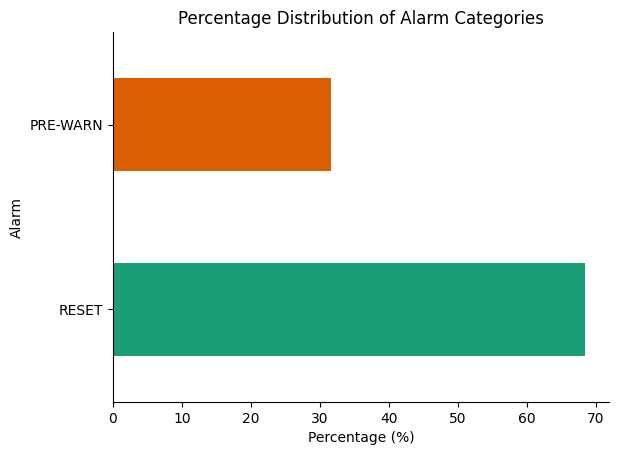

In [ ]:
# Calculate the percentage of each 'Alarm' category
alarm_counts = df_front_door['Alarm'].value_counts(normalize=True) * 100

# Plot the horizontal bar chart with percentages
alarm_counts.plot(kind='barh', color=sns.color_palette('Dark2', len(alarm_counts)))

# Display chart
plt.xlabel('Percentage (%)')
plt.ylabel('Alarm')
plt.title('Percentage Distribution of Alarm Categories')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

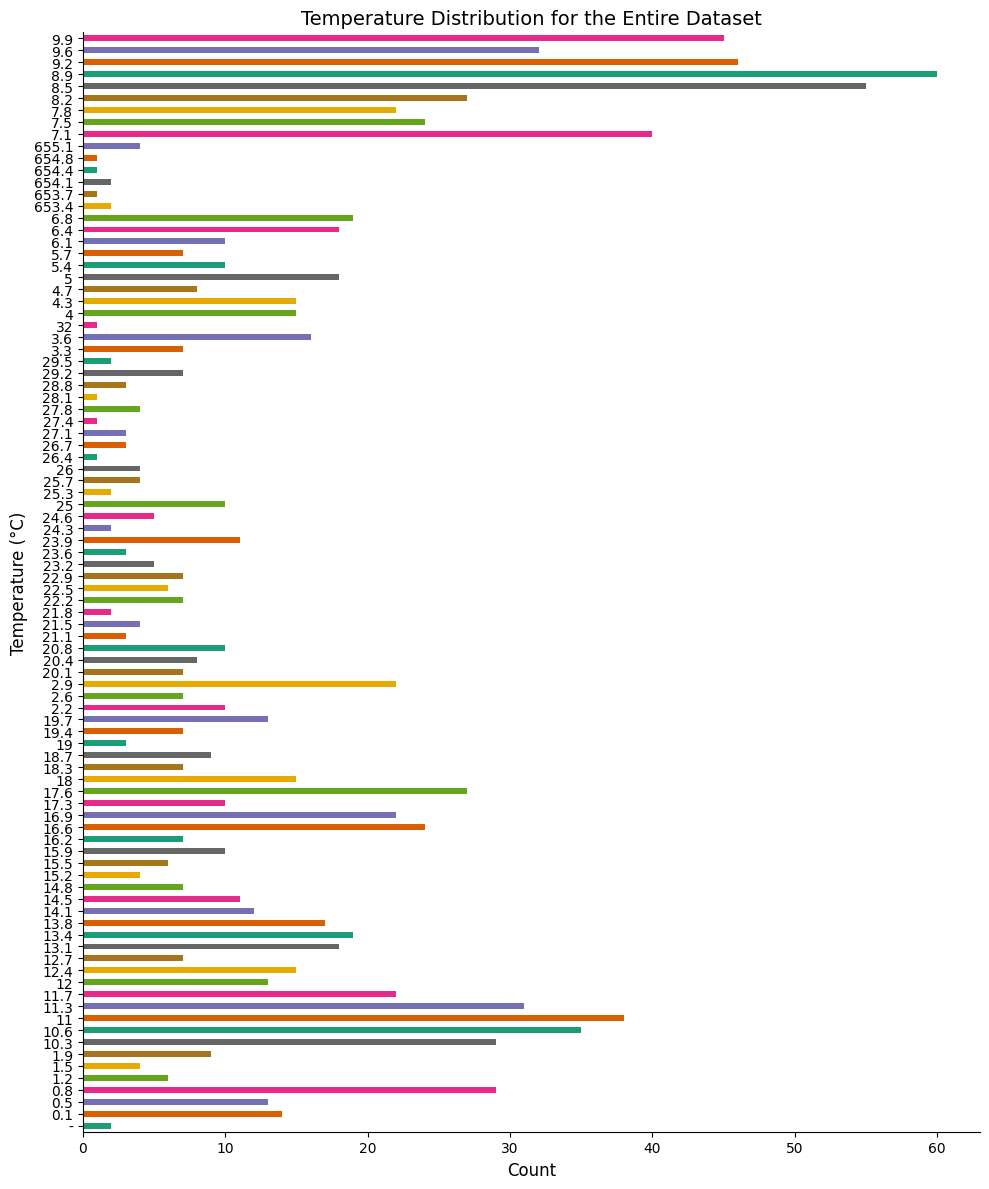

In [ ]:
# Check if the original dataset is not empty
if not df_front_door.empty:
    # Group by 'Temp' column and plot the distribution for the entire dataset with a larger figure size
    plt.figure(figsize=(10, 12))
    df_front_door.groupby('Temp').size().plot(kind='barh', color=sns.color_palette('Dark2'))

    # Add labels and title
    plt.title('Temperature Distribution for the Entire Dataset', fontsize=14)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Temperature (°C)', fontsize=12)
    plt.gca().spines[['top', 'right']].set_visible(False)
    plt.tight_layout()
    plt.show()
else:
    print("The dataset is empty. Cannot plot temperature distribution.")

*Values like 653.7°C are unrealistic so I will need to correct temperatures above 50°C*

### Data Clean and Preprocessing

In [ ]:
# Convert the 'Temp' column to numeric, replacing non-numeric values with NaN
df_front_door["Temp"] = pd.to_numeric(df_front_door["Temp"], errors="coerce")

# Replace anomalous high temperature values (above a reasonable threshold) with NaN
reasonable_temp_threshold = 60  # Assuming temperatures above 60°C are unrealistic
df_front_door["Temp"] = df_front_door["Temp"].where(
    df_front_door["Temp"] <= reasonable_temp_threshold, np.nan
)

# Fill NaN values with the mean temperature of the dataset (after removing anomalies)
mean_temp = df_front_door["Temp"].mean(skipna=True)
df_front_door["Temp"] = df_front_door["Temp"].fillna(mean_temp)

# Verify the changes
print(df_front_door["Temp"].describe())

count    1185.000000
mean       11.173976
std         6.354127
min         0.100000
25%         7.100000
50%         9.900000
75%        14.800000
max        32.000000
Name: Temp, dtype: float64


*The 25th percentile is 7.1°C, the median is 9.9°C, and the 75th percentile is 14.8°C, showing a well-spread distribution.*

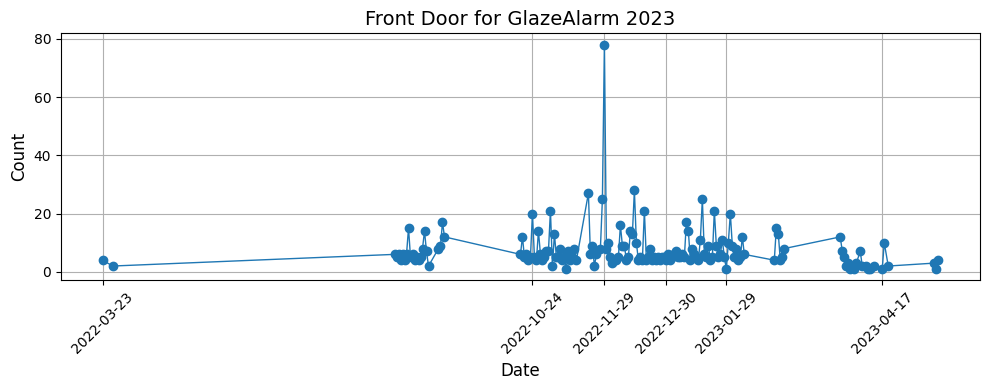

In [ ]:
# Convert the 'Timestamp' column to datetime
df_front_door["Timestamp"] = pd.to_datetime(df_front_door["Timestamp"], errors="coerce")

# Sort the DataFrame by 'Timestamp'
df_front_door = df_front_door.sort_values(by="Timestamp")

# Group data by date for the line chart
df_front_door["Date"] = df_front_door["Timestamp"].dt.date
daily_data = df_front_door.groupby("Date").size()

# Plot the line chart including the full timestamp
plt.figure(figsize=(10, 4))
plt.plot(daily_data.index, daily_data.values, marker="o", linestyle="-", linewidth=1)
plt.title("Front Door for GlazeAlarm 2023", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(True)
plt.xticks(daily_data.index[::30], rotation=45)
plt.tight_layout()
plt.show()

*Further Analysis is needed for the Outlier shown in the chart*

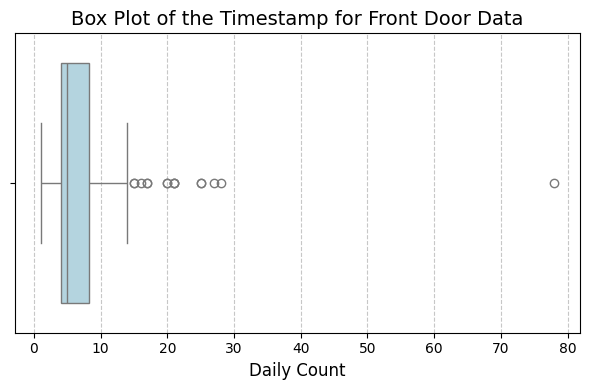

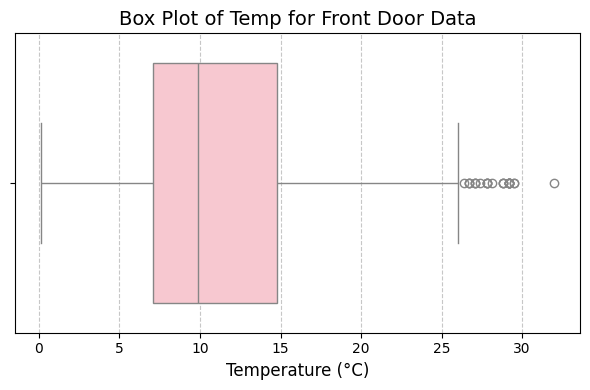

In [ ]:
# Boxplot display
daily_counts = df_front_door.groupby("Date").size().reset_index(name="Count")

# Create a box plot for the daily counts to detect outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=daily_counts["Count"], color="lightblue")
plt.title("Box Plot of the Timestamp for Front Door Data", fontsize=14)
plt.xlabel("Daily Count", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Create a box plot for the 'Temp' column to detect outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_front_door["Temp"], color="pink")
plt.title("Box Plot of Temp for Front Door Data", fontsize=14)
plt.xlabel("Temperature (°C)", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Identify the date corresponding to the outlier in daily counts
q1 = daily_counts["Count"].quantile(0.25)
q3 = daily_counts["Count"].quantile(0.75)
iqr = q3 - q1
outlier_threshold = q3 + 1.5 * iqr

# Filter for outlier days
outlier_days = daily_counts[daily_counts["Count"] > outlier_threshold]

# Display the outlier days and their counts
print(outlier_days)

           Date  Count
9    2022-08-23     15
22   2022-09-09     17
30   2022-10-24     20
39   2022-11-02     21
53   2022-11-21     27
59   2022-11-28     25
60   2022-11-29     78
67   2022-12-07     16
74   2022-12-14     28
79   2022-12-19     21
100  2023-01-09     17
108  2023-01-17     25
114  2023-01-23     21
122  2023-01-31     20
131  2023-02-23     15


*The outlier on 2022-11-29 is valid and reflects real activity logged by the system so a correction isn't needed*

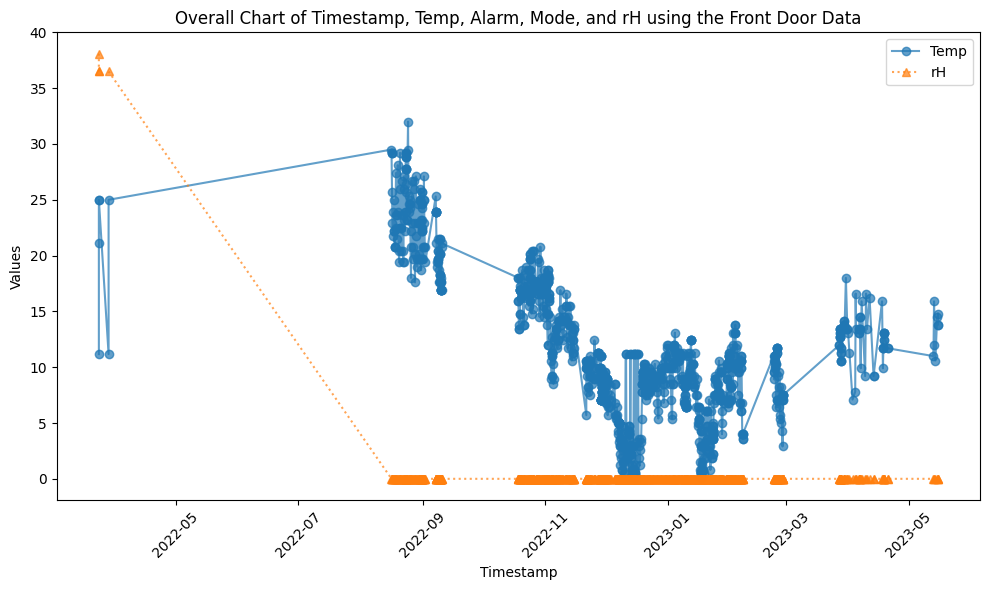

In [ ]:
# Convert non-numerical values in 'Mode' and 'Alarm' columns to numerical
# df_front_door["Mode"] = df_front_door["Mode"].astype("category").cat.codes
# df_front_door["Alarm"] = df_front_door["Alarm"].astype("category").cat.codes

# Step 3: Plot a combined graph for Timestamp, Alarm, Mode, rH, and Temp
plt.figure(figsize=(10, 6))

# Timestamp vs Temp
plt.plot(
    df_front_door["Timestamp"],
    df_front_door["Temp"],
    label="Temp",
    marker="o",
    linestyle="-",
    alpha=0.7,
)

# Timestamp vs Alarm
# plt.plot(df_front_door["Timestamp"], df_front_door["Alarm"], label="Alarm", marker="x", linestyle="--", alpha=0.7)

# Timestamp vs Mode
# plt.plot(df_front_door["Timestamp"], df_front_door["Mode"], label="Mode", marker="s", linestyle="-.", alpha=0.7)

# Convert 'rH' to numeric and plot
df_front_door["rH"] = pd.to_numeric(df_front_door["rH"], errors="coerce")
plt.plot(
    df_front_door["Timestamp"],
    df_front_door["rH"],
    label="rH",
    marker="^",
    linestyle=":",
    alpha=0.7,
)

# Adding labels, legend, and layout adjustments
plt.title("Overall Chart of Timestamp, Temp, Alarm, Mode, and rH using the Front Door Data")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Confirm the correction
print(df_front_door['rH'].describe())

count    1183.000000
mean        0.124768
std         2.143330
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        38.100000
Name: rH, dtype: float64


*The statistics confirm that the rH data is highly skewed and dominated by zeros, making it less meaningful for modeling purposes. It is reasonable to drop the rH column as it doesn't add significant value to the objective or target variable prediction.*

In [ ]:
# Drop the 'rH', 'Serial Number', and 'Name' columns from the dataset
df_cleaned = df_front_door.drop(columns=['rH', 'Serial Number', 'Name'])

# Define the cutoff date
cutoff_date = "2022-08-15"

# Convert the cutoff date to a datetime object
cutoff_date = pd.to_datetime(cutoff_date)

# Filter the dataset and create a new copy to avoid SettingWithCopyWarning
df_cleaned1 = df_cleaned[df_cleaned["Timestamp"] >= cutoff_date].copy()

# Handle Missing or Erroneous Temperature Values
df_cleaned1["Temp"] = pd.to_numeric(df_cleaned1["Temp"], errors="coerce")  # Convert Temp to numeric
reasonable_temp_threshold = 50  # Define a reasonable max Temp
df_cleaned1["Temp"] = df_cleaned1["Temp"].where(
    df_cleaned1["Temp"] <= reasonable_temp_threshold, np.nan
)  # Replace outliers
df_cleaned1["Temp"] = df_cleaned1["Temp"].interpolate(method="linear", limit_direction="both")  # Interpolate missing values

# Convert and Validate Timestamp
df_cleaned1["Timestamp"] = pd.to_datetime(df_cleaned1["Timestamp"], errors="coerce")  # Convert to datetime
df_cleaned1 = df_cleaned1.dropna(subset=["Timestamp"])  # Drop rows with invalid timestamps

# Validate `Mode` and `Alarm` Columns
# Ensure all values in Mode and Alarm are within a valid range
if df_cleaned1["Mode"].isnull().any() or df_cleaned1["Alarm"].isnull().any():
    print("Warning: Null values found in Mode or Alarm columns. Consider imputing them.")

# Validate and Display Final Cleaned Data
print("Cleaned Data After 8/15/2022:")
print(df_cleaned1.info())
print(df_cleaned1.head())

Cleaned Data After 8/15/2022:
<class 'pandas.core.frame.DataFrame'>
Index: 1179 entries, 1178 to 0
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Timestamp  1179 non-null   datetime64[ns]
 1   Mode       1179 non-null   object        
 2   Alarm      1179 non-null   object        
 3   Temp       1179 non-null   float64       
 4   Date       1179 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 55.3+ KB
None
               Timestamp   Mode     Alarm  Temp        Date
1178 2022-08-16 11:24:21  STATE     RESET  29.5  2022-08-16
1177 2022-08-16 12:16:09  STATE  PRE-WARN  29.2  2022-08-16
1176 2022-08-16 12:16:53  STATE     RESET  29.2  2022-08-16
1175 2022-08-16 12:17:12  STATE  PRE-WARN  29.2  2022-08-16
1174 2022-08-16 17:37:52  STATE     RESET  25.7  2022-08-16


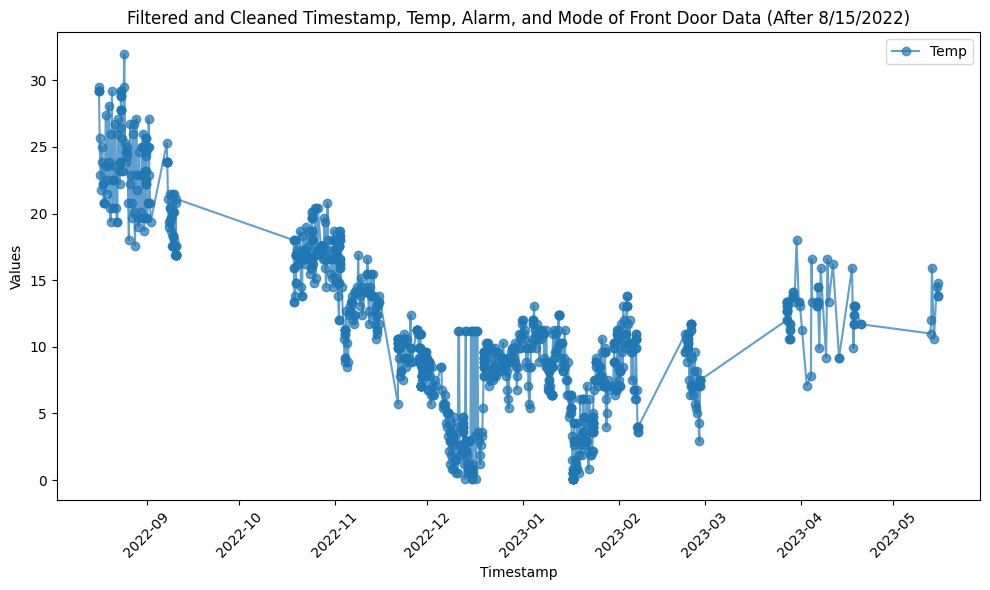

In [ ]:
# Visualize the updated data to confirm
plt.figure(figsize=(10, 6))

# Plot Timestamp vs Temp
plt.plot(
    df_cleaned1["Timestamp"],
    df_cleaned1["Temp"],
    label="Temp",
    marker="o",
    linestyle="-",
    alpha=0.7,
)

# Uncomment below lines if you want to plot Alarm and Mode as well
# plt.plot(df_cleaned1["Timestamp"], df_cleaned1["Alarm"], label="Alarm", marker="x", linestyle="--", alpha=0.7)
# plt.plot(df_cleaned1["Timestamp"], df_cleaned1["Mode"], label="Mode", marker="s", linestyle="-.", alpha=0.7)

# Formatting the plot
plt.title("Filtered and Cleaned Timestamp, Temp, Alarm, and Mode of Front Door Data (After 8/15/2022)")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

*Display Data for Front Door Data in 3 Month Range*

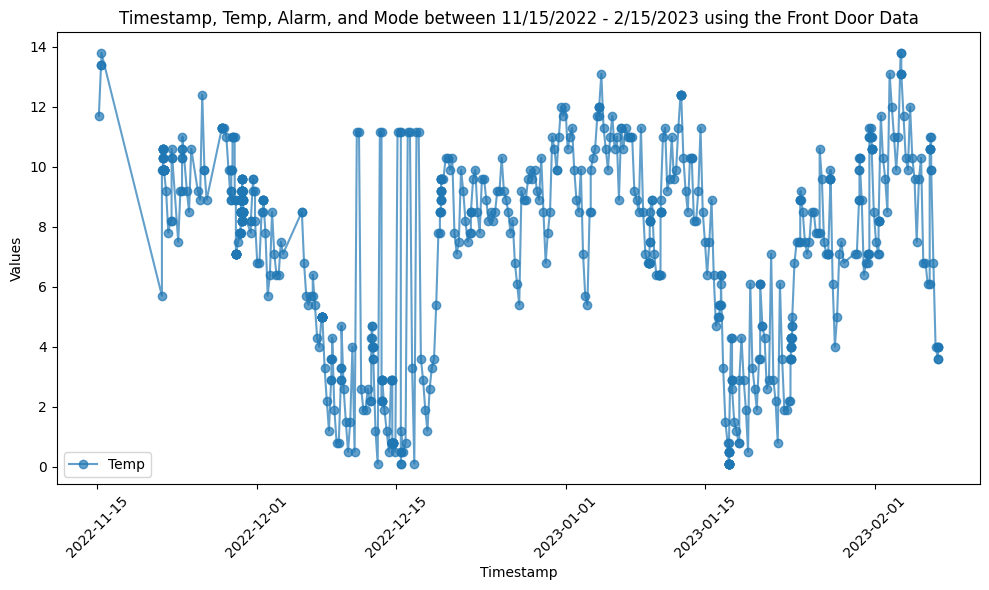

In [ ]:
# Filter the DataFrame to include only data between 11/2022 and 2/2023
df_filtered = df_cleaned1[
    (df_cleaned1["Timestamp"] >= "2022-11-15") & (df_cleaned1["Timestamp"] <= "2023-02-15")
]

# Plot the combined graph for the filtered data
plt.figure(figsize=(10, 6))

# Timestamp vs Temp
plt.plot(
    df_filtered["Timestamp"],
    df_filtered["Temp"],
    label="Temp",
    marker="o",
    linestyle="-",
    alpha=0.7,
)

# Uncomment below lines if you want to plot Alarm and Mode as well
# plt.plot(df_filtered["Timestamp"], df_filtered["Alarm"], label="Alarm", marker="x", linestyle="--", alpha=0.7)
# plt.plot(df_filtered["Timestamp"], df_filtered["Mode"], label="Mode", marker="s", linestyle="-.", alpha=0.7)

# Adding labels, legend, and layout adjustments
plt.title("Timestamp, Temp, Alarm, and Mode between 11/15/2022 - 2/15/2023 using the Front Door Data")
plt.xlabel("Timestamp")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

*Saved Clean Version of Front Door Data to Use for Model Predictions*

In [ ]:
# Ensure the directory exists
output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)

# Define the output file path
cleaned_file_path = os.path.join(output_dir, "Front_Door_Cleaned.csv")

# Save the filtered and cleaned dataset
df_cleaned1.to_csv(cleaned_file_path, index=False)

# Confirm the save operation
print(f"Dataset saved successfully at: {cleaned_file_path}")

Dataset saved successfully at: ./data/Front_Door_Cleaned.csv


# Invisible Systems 2023
## Sensor 2: EcoLab Ground Data
*We are using EcoLab Ground as that has ppm, rH and Temperature. Smarthouse Ground floor has alot more but more sensors that don't have full meaning to this project like IAQ, VOC, Light, Floor pressure and Floor temperature*
### Data Understanding and EDA

In [ ]:
# Check Dataframe
df_inv.head()

Sensor             DateTime  Value  Max  Min Unit
0  EcoLab Ground (CO107)  2022-12-31 23:53:24  518.0  NaN  NaN  ppm
1  EcoLab Ground (CO107)  2023-01-01 00:00:55  520.0  NaN  NaN  ppm
2  EcoLab Ground (CO107)  2023-01-01 00:08:23  505.0  NaN  NaN  ppm
3  EcoLab Ground (CO107)  2023-01-01 00:15:52  491.0  NaN  NaN  ppm
4  EcoLab Ground (CO107)  2023-01-01 00:23:22  509.0  NaN  NaN  ppm

In [ ]:
# Remove the 'Max' and 'Min' columns
df_inv = df_inv.drop(columns=['Max', 'Min'])
df_inv['DateTime'] = pd.to_datetime(df_inv['DateTime'])

In [ ]:
df_inv.shape
df_inv.info()
df_inv.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179682 entries, 0 to 179681
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   Sensor    179682 non-null  object        
 1   DateTime  179682 non-null  datetime64[ns]
 2   Value     179682 non-null  float64       
 3   Unit      179682 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.5+ MB


Sensor            DateTime  Value Unit
0  EcoLab Ground (CO107) 2022-12-31 23:53:24  518.0  ppm
1  EcoLab Ground (CO107) 2023-01-01 00:00:55  520.0  ppm
2  EcoLab Ground (CO107) 2023-01-01 00:08:23  505.0  ppm
3  EcoLab Ground (CO107) 2023-01-01 00:15:52  491.0  ppm
4  EcoLab Ground (CO107) 2023-01-01 00:23:22  509.0  ppm

In [ ]:
# Filter data for each unit
df_ppm = df_inv[df_inv['Unit'] == 'ppm']  # For ppm
df_rh = df_inv[df_inv['Unit'] == '%RH']   # For %RH
df_c = df_inv[df_inv['Unit'] == '°C']     # For °C

# Check the filtered data
print(df_ppm.head())
print(df_rh.head())
print(df_c.head())

                  Sensor            DateTime  Value Unit
0  EcoLab Ground (CO107) 2022-12-31 23:53:24  518.0  ppm
1  EcoLab Ground (CO107) 2023-01-01 00:00:55  520.0  ppm
2  EcoLab Ground (CO107) 2023-01-01 00:08:23  505.0  ppm
3  EcoLab Ground (CO107) 2023-01-01 00:15:52  491.0  ppm
4  EcoLab Ground (CO107) 2023-01-01 00:23:22  509.0  ppm
                     Sensor            DateTime  Value Unit
59894  EcoLab Ground (H107) 2022-12-31 23:53:24   73.0  %RH
59895  EcoLab Ground (H107) 2023-01-01 00:00:55   73.0  %RH
59896  EcoLab Ground (H107) 2023-01-01 00:08:23   73.0  %RH
59897  EcoLab Ground (H107) 2023-01-01 00:15:52   73.0  %RH
59898  EcoLab Ground (H107) 2023-01-01 00:23:22   73.0  %RH
                      Sensor            DateTime  Value Unit
119788  EcoLab Ground (T107) 2022-12-31 23:53:24   12.3   °C
119789  EcoLab Ground (T107) 2023-01-01 00:00:55   12.4   °C
119790  EcoLab Ground (T107) 2023-01-01 00:08:23   12.4   °C
119791  EcoLab Ground (T107) 2023-01-01 00:15:52   12.

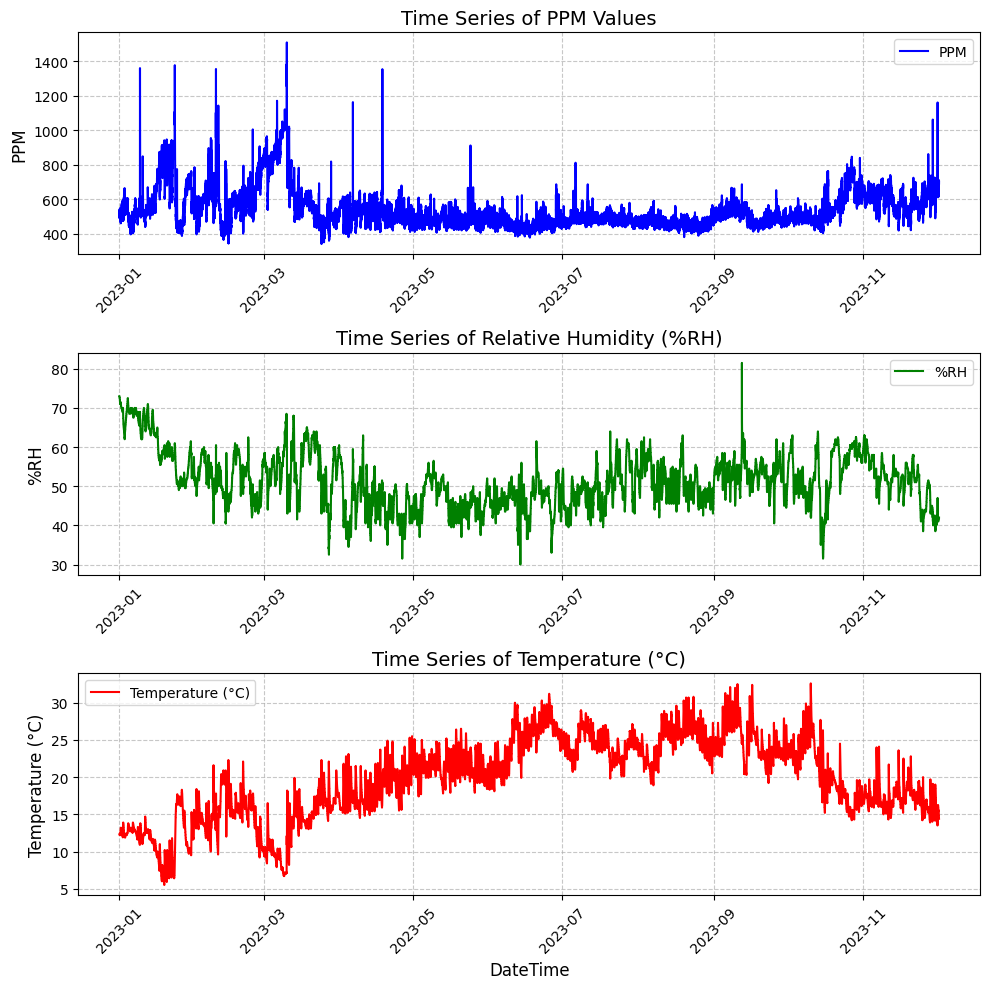

In [ ]:
# Visualizing EcoLab Ground Data: PPM, RH, and Temperature
fig, axes = plt.subplots(3, 1, figsize=(10, 10))

# Plot ppm
axes[0].plot(df_ppm["DateTime"], df_ppm["Value"], color="blue", label="PPM")
axes[0].set_title("Time Series of PPM Values", fontsize=14)
axes[0].set_ylabel("PPM", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].legend(fontsize=10)

# Plot %RH
axes[1].plot(df_rh["DateTime"], df_rh["Value"], color="green", label="%RH")
axes[1].set_title("Time Series of Relative Humidity (%RH)", fontsize=14)
axes[1].set_ylabel("%RH", fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.7)
axes[1].legend(fontsize=10)

# Plot °C
axes[2].plot(df_c["DateTime"], df_c["Value"], color="red", label="Temperature (°C)")
axes[2].set_title("Time Series of Temperature (°C)", fontsize=14)
axes[2].set_xlabel("DateTime", fontsize=12)
axes[2].set_ylabel("Temperature (°C)", fontsize=12)
axes[2].grid(True, linestyle="--", alpha=0.7)
axes[2].legend(fontsize=10)

# Adjust x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis="x", rotation=45)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

### Data Clean and Preprocessing
*Handle Outliers in EcoLab Ground Data*

In [ ]:
# Convert DateTime column to datetime format
df_inv["DateTime"] = pd.to_datetime(df_inv["DateTime"], errors="coerce")

# Remove rows with invalid DateTime or missing data
df_inv = df_inv.dropna(subset=["DateTime", "Value"])

# Filter dataset for relevant units: ppm, %RH, °C
df_ppm = df_inv[df_inv["Unit"] == "ppm"].copy()
df_rh = df_inv[df_inv["Unit"] == "%RH"].copy()
df_temp = df_inv[df_inv["Unit"] == "°C"].copy()

# Ensure 'Value' column is numeric
df_ppm["Value"] = pd.to_numeric(df_ppm["Value"], errors="coerce")
df_rh["Value"] = pd.to_numeric(df_rh["Value"], errors="coerce")
df_temp["Value"] = pd.to_numeric(df_temp["Value"], errors="coerce")

# Handle outliers and interpolate
# PPM
ppm_threshold = 3000  # Set threshold
df_ppm["Value"] = df_ppm["Value"].where(df_ppm["Value"] <= ppm_threshold, np.nan)
df_ppm["Value"] = df_ppm["Value"].interpolate(method="linear", limit_direction="both")

# %RH
rh_min, rh_max = 10, 90  # Set reasonable range for %RH
df_rh["Value"] = df_rh["Value"].where((df_rh["Value"] >= rh_min) & (df_rh["Value"] <= rh_max), np.nan)
df_rh["Value"] = df_rh["Value"].interpolate(method="linear", limit_direction="both")

# Temperature (°C)
temp_threshold = 60  # Set threshold
df_temp["Value"] = df_temp["Value"].where(df_temp["Value"] <= temp_threshold, np.nan)
df_temp["Value"] = df_temp["Value"].interpolate(method="linear", limit_direction="both")

# Combine cleaned datasets
df2_clean = pd.concat([df_ppm, df_rh, df_temp]).sort_values(by="DateTime").reset_index(drop=True)

# Verify the structure of the cleaned dataset
print(df2_clean.head())

                  Sensor            DateTime  Value Unit
0  EcoLab Ground (CO107) 2022-12-31 23:53:24  518.0  ppm
1   EcoLab Ground (H107) 2022-12-31 23:53:24   73.0  %RH
2   EcoLab Ground (T107) 2022-12-31 23:53:24   12.3   °C
3  EcoLab Ground (CO107) 2023-01-01 00:00:55  520.0  ppm
4   EcoLab Ground (H107) 2023-01-01 00:00:55   73.0  %RH


In [ ]:
# Display the column names of the cleaned dataset
df2_clean.columns

Index(['Sensor', 'DateTime', 'Value', 'Unit'], dtype='object')

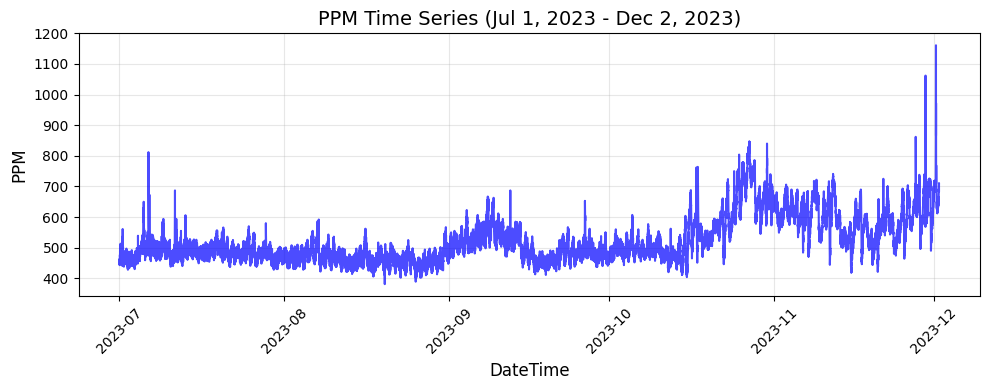

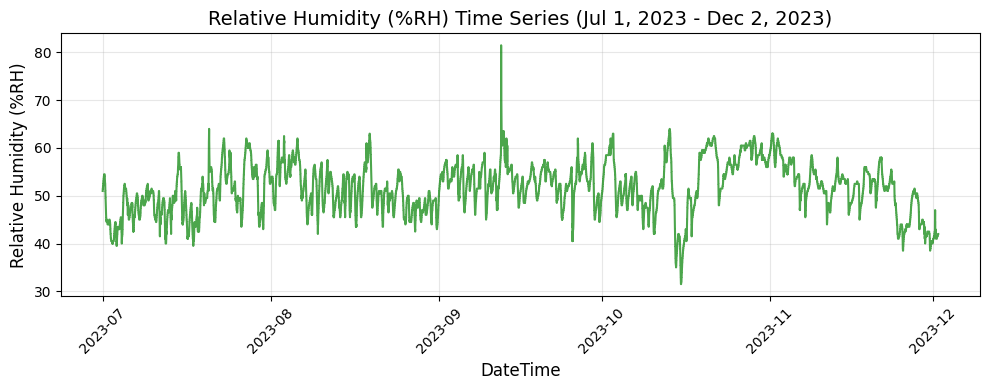

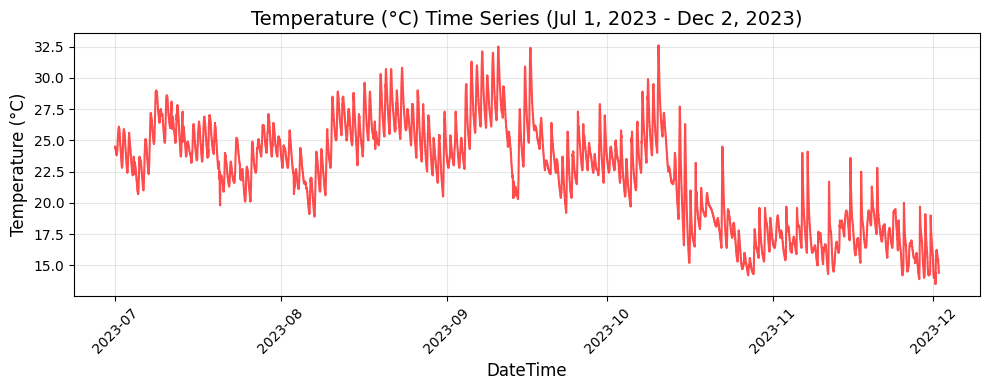

In [ ]:
# Filter each subset for the date range
start_date = "2023-07-01"
end_date = "2023-12-02"

df_ppm_filtered = df_ppm[
    (df_ppm["DateTime"] >= start_date) & (df_ppm["DateTime"] <= end_date)
]
df_rh_filtered = df_rh[
    (df_rh["DateTime"] >= start_date) & (df_rh["DateTime"] <= end_date)
]
df_temp_filtered = df_temp[
    (df_temp["DateTime"] >= start_date) & (df_temp["DateTime"] <= end_date)
]

# Plotting PPM
plt.figure(figsize=(10, 4))
plt.plot(
    df_ppm_filtered["DateTime"],
    df_ppm_filtered["Value"],
    label="PPM",
    color="blue",
    alpha=0.7,
)
plt.title("PPM Time Series (Jul 1, 2023 - Dec 2, 2023)", fontsize=14)
plt.xlabel("DateTime", fontsize=12)
plt.ylabel("PPM", fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting RH
plt.figure(figsize=(10, 4))
plt.plot(
    df_rh_filtered["DateTime"],
    df_rh_filtered["Value"],
    label="%RH",
    color="green",
    alpha=0.7,
)
plt.title("Relative Humidity (%RH) Time Series (Jul 1, 2023 - Dec 2, 2023)", fontsize=14)
plt.xlabel("DateTime", fontsize=12)
plt.ylabel("Relative Humidity (%RH)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plotting Temperature
plt.figure(figsize=(10, 4))
plt.plot(
    df_temp_filtered["DateTime"],
    df_temp_filtered["Value"],
    label="Temp (°C)",
    color="red",
    alpha=0.7,
)
plt.title("Temperature (°C) Time Series (Jul 1, 2023 - Dec 2, 2023)", fontsize=14)
plt.xlabel("DateTime", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

*Saved Clean Version of EcoLab Ground Data to Use for Model Predictions*

In [ ]:
# Define the output directory and file path
output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)

cleaned_file_path = os.path.join(output_dir, "EcoLab_Ground_Cleaned.csv")

# Save the cleaned dataset to a CSV file
df2_clean.to_csv(cleaned_file_path, index=False)

# Confirm the save operation
print(f"Dataset saved successfully at: {cleaned_file_path}")

Dataset saved successfully at: ./data/EcoLab_Ground_Cleaned.csv


# Weather Link Indoor and Outdoor 2023
## Sensor 3 Data: Weather Link Indoor
### Data Understanding and EDA

In [ ]:
# Dataframe Initial Head
df_wLink.head()

Date & Time  Inside Temp - °C  High Inside Temp - °C  \
0  1/1/23 00:00                13                     13   
1  1/1/23 00:15                13                     13   
2  1/1/23 00:30                13                     13   
3  1/1/23 00:45                13                     14   
4  1/1/23 01:00                13                     14   

   Low Inside Temp - °C  Inside Hum - %  High Inside Hum - %  \
0                    13              68                   68   
1                    13              68                   69   
2                    13              68                   69   
3                    13              68                   68   
4                    13              68                   68   

   Low Inside Hum - %  Inside Dew Point - °C  Inside Heat Index - °C  \
0                  68                      8                      13   
1                  68                      8                      13   
2                  68                      8                      13   
3                  68                      8                      13   
4                  68                      8                      13   

   Barometer - mb  High Bar - mb  Low Bar - mb  Absolute Pressure - mb  
0          1002.6         1002.6        1002.6                   999.6  
1          1002.7         1002.8        1002.6                   999.7  
2          1002.6         1002.9        1002.6                   999.6  
3          1002.7         1002.9        1002.6                   999.8  
4          1002.7         1002.8        1002.7                   999.7

In [ ]:
# Print Initial Data
df_wLink.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52864 entries, 0 to 52863
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date & Time             52864 non-null  object 
 1   Inside Temp - °C        52864 non-null  int64  
 2   High Inside Temp - °C   52864 non-null  int64  
 3   Low Inside Temp - °C    52864 non-null  int64  
 4   Inside Hum - %          52864 non-null  int64  
 5   High Inside Hum - %     52864 non-null  int64  
 6   Low Inside Hum - %      52864 non-null  int64  
 7   Inside Dew Point - °C   52864 non-null  int64  
 8   Inside Heat Index - °C  52864 non-null  int64  
 9   Barometer - mb          52864 non-null  float64
 10  High Bar - mb           52864 non-null  float64
 11  Low Bar - mb            52864 non-null  float64
 12  Absolute Pressure - mb  52864 non-null  float64
dtypes: float64(4), int64(8), object(1)
memory usage: 5.2+ MB


### Data Cleaning and Preprocessing
*Feature Engineering*

In [ ]:
# Create the cleaned dataset
df_wLink_cleaned = df_wLink.copy()

# Retain Relevant Columns and Create Derived Features
df_wLink_cleaned["Temp Range - °C"] = (
    df_wLink_cleaned["High Inside Temp - °C"] - df_wLink_cleaned["Low Inside Temp - °C"]
)
df_wLink_cleaned["Humidity Range - %"] = (
    df_wLink_cleaned["High Inside Hum - %"] - df_wLink_cleaned["Low Inside Hum - %"]
)
df_wLink_cleaned["Pressure Range - mb"] = (
    df_wLink_cleaned["High Bar - mb"] - df_wLink_cleaned["Low Bar - mb"]
)

# Remove Unnecessary Columns
df_wLink_cleaned = df_wLink_cleaned.drop(
    columns=[
        "High Inside Temp - °C",
        "Low Inside Temp - °C",
        "High Inside Hum - %",
        "Low Inside Hum - %",
        "High Bar - mb",
        "Low Bar - mb",
    ],
    errors="ignore",
)

*Standardize Date Format*

In [ ]:
# Standardize the Date Format
def standardize_date(date_str):
    try:
        dt = datetime.strptime(date_str, "%d/%m/%Y %H:%M")  # e.g., "1/1/2023 0:00"
    except ValueError:
        try:
            dt = datetime.strptime(date_str, "%d/%m/%y %H:%M")  # e.g., "13/1/23 00:00"
        except ValueError:
            return None
    return dt

# Apply standardization to the 'Date & Time' column
df_wLink_cleaned["Date & Time"] = df_wLink_cleaned["Date & Time"].apply(standardize_date)

# Convert to pandas datetime format
df_wLink_cleaned["Date & Time"] = pd.to_datetime(df_wLink_cleaned["Date & Time"], errors="coerce")

*Display Clean Data*

In [ ]:
# Verify the Cleaned DataFrame
print("\nCleaned Dataset Info:")
print(df_wLink_cleaned.info())

# Display first few rows
print("\nFirst 5 Rows of Cleaned Data:")
print(df_wLink_cleaned.head())

# Print New Columns
print("\nColumns in Cleaned DataFrame:")
print(df_wLink_cleaned.columns)


Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52864 entries, 0 to 52863
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date & Time             52864 non-null  datetime64[ns]
 1   Inside Temp - °C        52864 non-null  int64         
 2   Inside Hum - %          52864 non-null  int64         
 3   Inside Dew Point - °C   52864 non-null  int64         
 4   Inside Heat Index - °C  52864 non-null  int64         
 5   Barometer - mb          52864 non-null  float64       
 6   Absolute Pressure - mb  52864 non-null  float64       
 7   Temp Range - °C         52864 non-null  int64         
 8   Humidity Range - %      52864 non-null  int64         
 9   Pressure Range - mb     52864 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(6)
memory usage: 4.0 MB
None

First 5 Rows of Cleaned Data:
          Date & Time  Inside Temp - °C  In

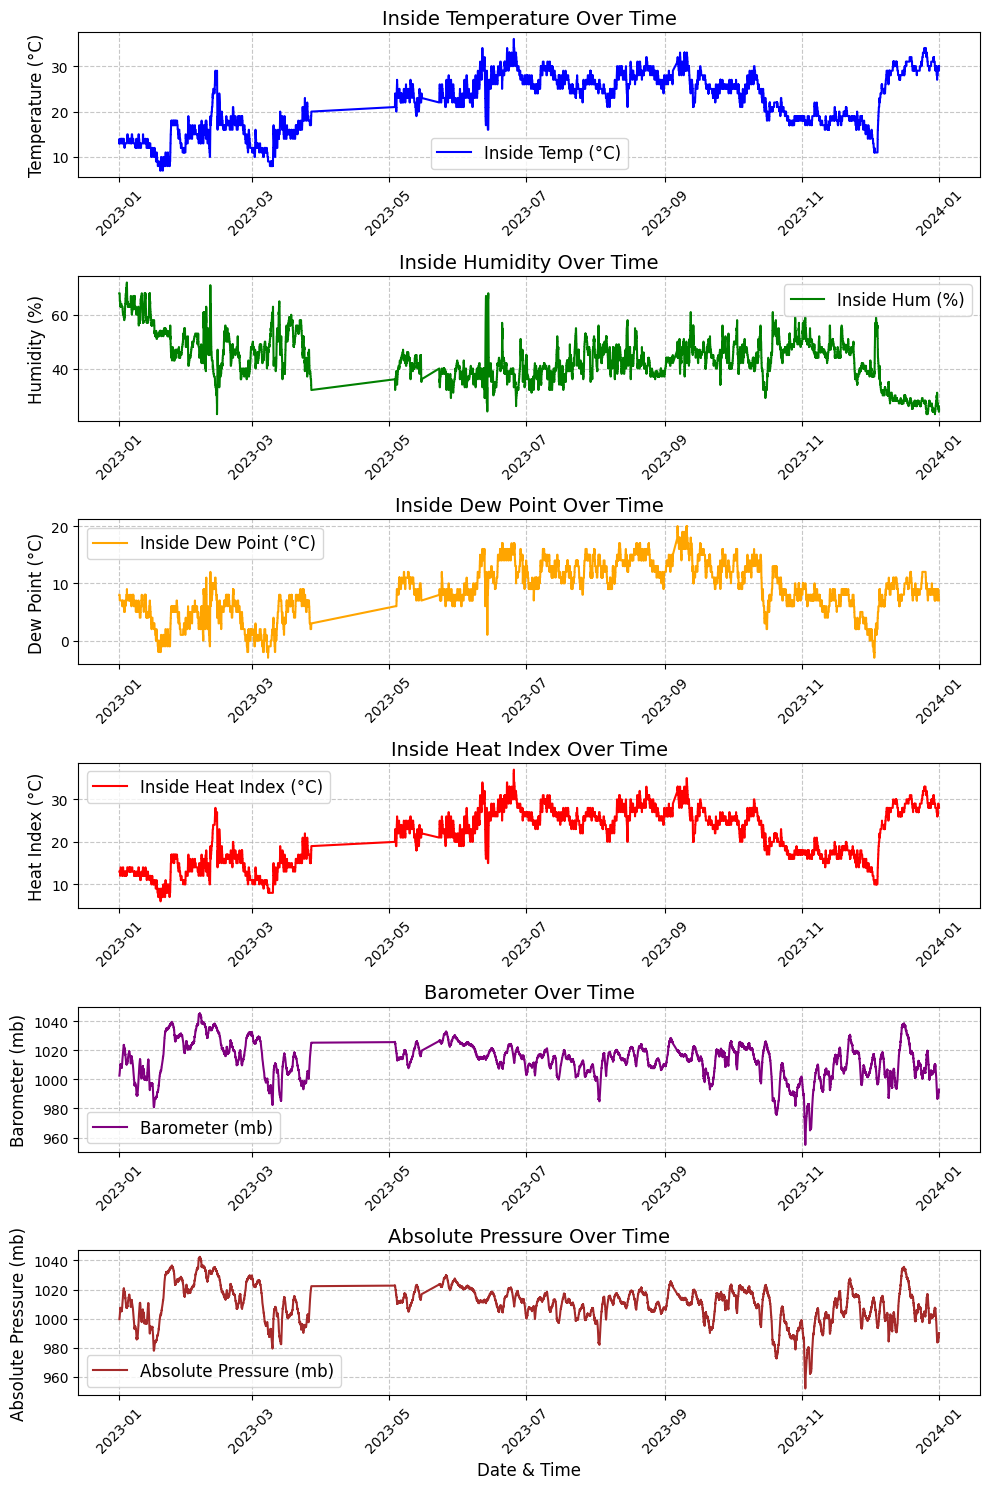

In [ ]:
# Visualization for the Entire Dataset
fig, axes = plt.subplots(6, 1, figsize=(10, 15))

# Plot Inside Temperature
axes[0].plot(
    df_wLink_cleaned["Date & Time"],
    df_wLink_cleaned["Inside Temp - °C"],
    color="blue",
    label="Inside Temp (°C)",
)
axes[0].set_title("Inside Temperature Over Time", fontsize=14)
axes[0].set_ylabel("Temperature (°C)", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].legend(fontsize=12)

# Plot Inside Humidity
axes[1].plot(
    df_wLink_cleaned["Date & Time"],
    df_wLink_cleaned["Inside Hum - %"],
    color="green",
    label="Inside Hum (%)",
)
axes[1].set_title("Inside Humidity Over Time", fontsize=14)
axes[1].set_ylabel("Humidity (%)", fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.7)
axes[1].legend(fontsize=12)

# Plot Inside Dew Point
axes[2].plot(
    df_wLink_cleaned["Date & Time"],
    df_wLink_cleaned["Inside Dew Point - °C"],
    color="orange",
    label="Inside Dew Point (°C)",
)
axes[2].set_title("Inside Dew Point Over Time", fontsize=14)
axes[2].set_ylabel("Dew Point (°C)", fontsize=12)
axes[2].grid(True, linestyle="--", alpha=0.7)
axes[2].legend(fontsize=12)

# Plot Inside Heat Index
axes[3].plot(
    df_wLink_cleaned["Date & Time"],
    df_wLink_cleaned["Inside Heat Index - °C"],
    color="red",
    label="Inside Heat Index (°C)",
)
axes[3].set_title("Inside Heat Index Over Time", fontsize=14)
axes[3].set_ylabel("Heat Index (°C)", fontsize=12)
axes[3].grid(True, linestyle="--", alpha=0.7)
axes[3].legend(fontsize=12)

# Plot Barometer
axes[4].plot(
    df_wLink_cleaned["Date & Time"],
    df_wLink_cleaned["Barometer - mb"],
    color="purple",
    label="Barometer (mb)",
)
axes[4].set_title("Barometer Over Time", fontsize=14)
axes[4].set_ylabel("Barometer (mb)", fontsize=12)
axes[4].grid(True, linestyle="--", alpha=0.7)
axes[4].legend(fontsize=12)

# Plot Absolute Pressure
axes[5].plot(
    df_wLink_cleaned["Date & Time"],
    df_wLink_cleaned["Absolute Pressure - mb"],
    color="brown",
    label="Absolute Pressure (mb)",
)
axes[5].set_title("Absolute Pressure Over Time", fontsize=14)
axes[5].set_xlabel("Date & Time", fontsize=12)
axes[5].set_ylabel("Absolute Pressure (mb)", fontsize=12)
axes[5].grid(True, linestyle="--", alpha=0.7)
axes[5].legend(fontsize=12)

# Rotate x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis="x", rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# View Filtered Data (6-month range)
# Define the date range
start_date = "2023-07-01"
end_date = "2023-12-02"  # Standardized format for consistency

# Filter the DataFrame
df_wLink_filtered = df_wLink_cleaned[
    (df_wLink_cleaned["Date & Time"] >= start_date) &
    (df_wLink_cleaned["Date & Time"] <= end_date)
]

# Check the filtered data
print(df_wLink_filtered.head())

              Date & Time  Inside Temp - °C  Inside Hum - %  \
13026 2023-07-01 00:00:00                27              43   
13027 2023-07-01 00:15:00                27              43   
13028 2023-07-01 00:30:00                27              44   
13029 2023-07-01 00:45:00                27              44   
13030 2023-07-01 01:00:00                27              44   

       Inside Dew Point - °C  Inside Heat Index - °C  Barometer - mb  \
13026                     13                      26          1005.3   
13027                     13                      26          1005.1   
13028                     13                      26          1005.0   
13029                     13                      26          1004.8   
13030                     13                      26          1004.8   

       Absolute Pressure - mb  Temp Range - °C  Humidity Range - %  \
13026                  1002.3                0                   1   
13027                  1002.2                0  

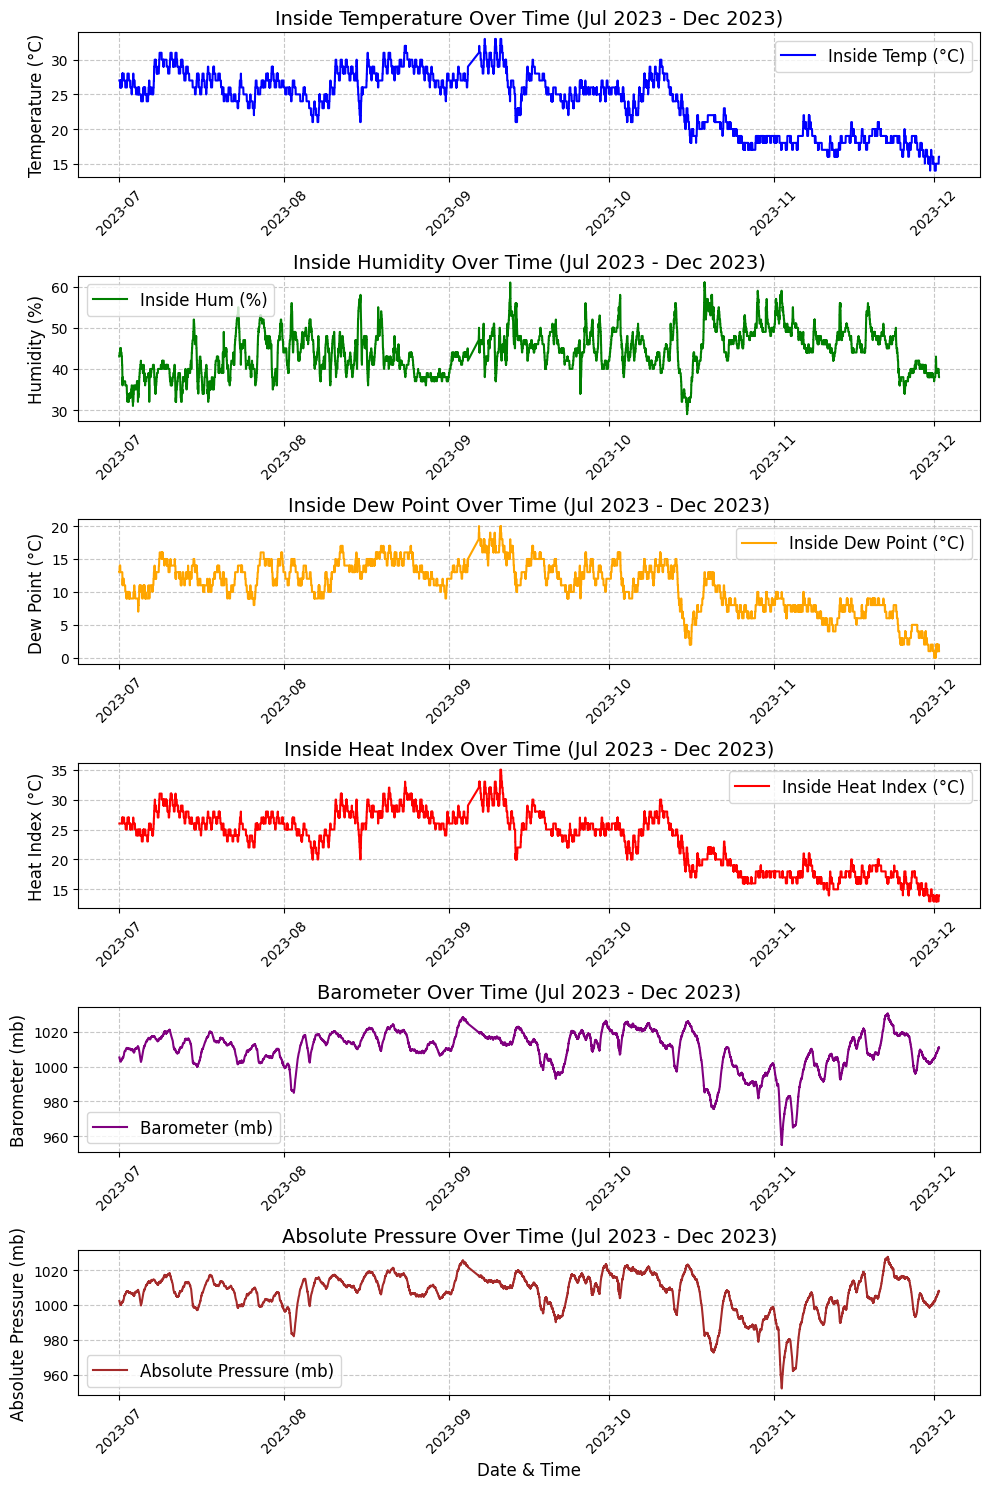

In [ ]:
# Create a figure with 6 subplots
fig, axes = plt.subplots(6, 1, figsize=(10, 15))

# Plot Inside Temperature
axes[0].plot(
    df_wLink_filtered["Date & Time"],
    df_wLink_filtered["Inside Temp - °C"],
    color="blue",
    label="Inside Temp (°C)",
)
axes[0].set_title("Inside Temperature Over Time (Jul 2023 - Dec 2023)", fontsize=14)
axes[0].set_ylabel("Temperature (°C)", fontsize=12)
axes[0].grid(True, linestyle="--", alpha=0.7)
axes[0].legend(fontsize=12)

# Plot Inside Humidity
axes[1].plot(
    df_wLink_filtered["Date & Time"],
    df_wLink_filtered["Inside Hum - %"],
    color="green",
    label="Inside Hum (%)",
)
axes[1].set_title("Inside Humidity Over Time (Jul 2023 - Dec 2023)", fontsize=14)
axes[1].set_ylabel("Humidity (%)", fontsize=12)
axes[1].grid(True, linestyle="--", alpha=0.7)
axes[1].legend(fontsize=12)

# Plot Inside Dew Point
axes[2].plot(
    df_wLink_filtered["Date & Time"],
    df_wLink_filtered["Inside Dew Point - °C"],
    color="orange",
    label="Inside Dew Point (°C)",
)
axes[2].set_title("Inside Dew Point Over Time (Jul 2023 - Dec 2023)", fontsize=14)
axes[2].set_ylabel("Dew Point (°C)", fontsize=12)
axes[2].grid(True, linestyle="--", alpha=0.7)
axes[2].legend(fontsize=12)

# Plot Inside Heat Index
axes[3].plot(
    df_wLink_filtered["Date & Time"],
    df_wLink_filtered["Inside Heat Index - °C"],
    color="red",
    label="Inside Heat Index (°C)",
)
axes[3].set_title("Inside Heat Index Over Time (Jul 2023 - Dec 2023)", fontsize=14)
axes[3].set_ylabel("Heat Index (°C)", fontsize=12)
axes[3].grid(True, linestyle="--", alpha=0.7)
axes[3].legend(fontsize=12)

# Plot Barometer
axes[4].plot(
    df_wLink_filtered["Date & Time"],
    df_wLink_filtered["Barometer - mb"],
    color="purple",
    label="Barometer (mb)",
)
axes[4].set_title("Barometer Over Time (Jul 2023 - Dec 2023)", fontsize=14)
axes[4].set_ylabel("Barometer (mb)", fontsize=12)
axes[4].grid(True, linestyle="--", alpha=0.7)
axes[4].legend(fontsize=12)

# Plot Absolute Pressure
axes[5].plot(
    df_wLink_filtered["Date & Time"],
    df_wLink_filtered["Absolute Pressure - mb"],
    color="brown",
    label="Absolute Pressure (mb)",
)
axes[5].set_title("Absolute Pressure Over Time (Jul 2023 - Dec 2023)", fontsize=14)
axes[5].set_xlabel("Date & Time", fontsize=12)
axes[5].set_ylabel("Absolute Pressure (mb)", fontsize=12)
axes[5].grid(True, linestyle="--", alpha=0.7)
axes[5].legend(fontsize=12)

# Rotate x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis="x", rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

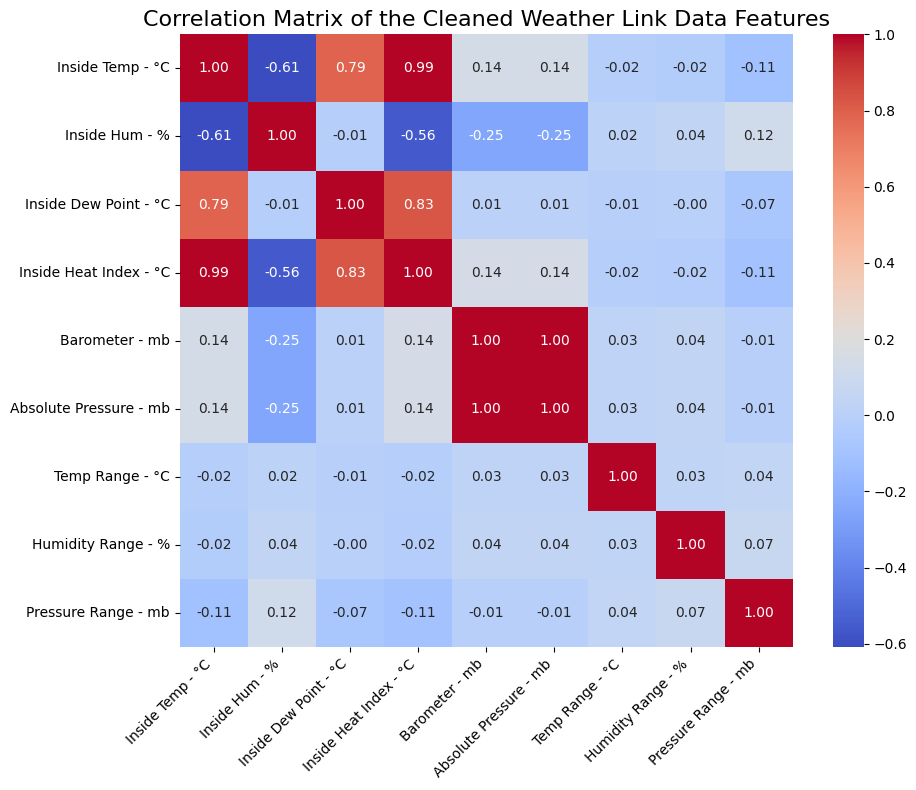

In [ ]:
# Calculate correlation matrix for filtered data
correlation_matrix = df_wLink_cleaned.drop(columns=["Date & Time"]).corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
)

plt.title("Correlation Matrix of the Cleaned Weather Link Data Features", fontsize=16)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

*The correlation matrix shows that Inside Temp - °C, Inside Heat Index - °C, and Inside Dew Point - °C are strongly correlated, indicating these features are interrelated and may provide redundant information. Inside Hum - % is negatively correlated with temperature and heat index, reflecting the inverse relationship between temperature and relative humidity. Barometer - mb and Absolute Pressure - mb are perfectly correlated, while features like Pressure Range - mb and Temp Range - °C exhibit weak correlations with most variables, suggesting limited predictive value.*

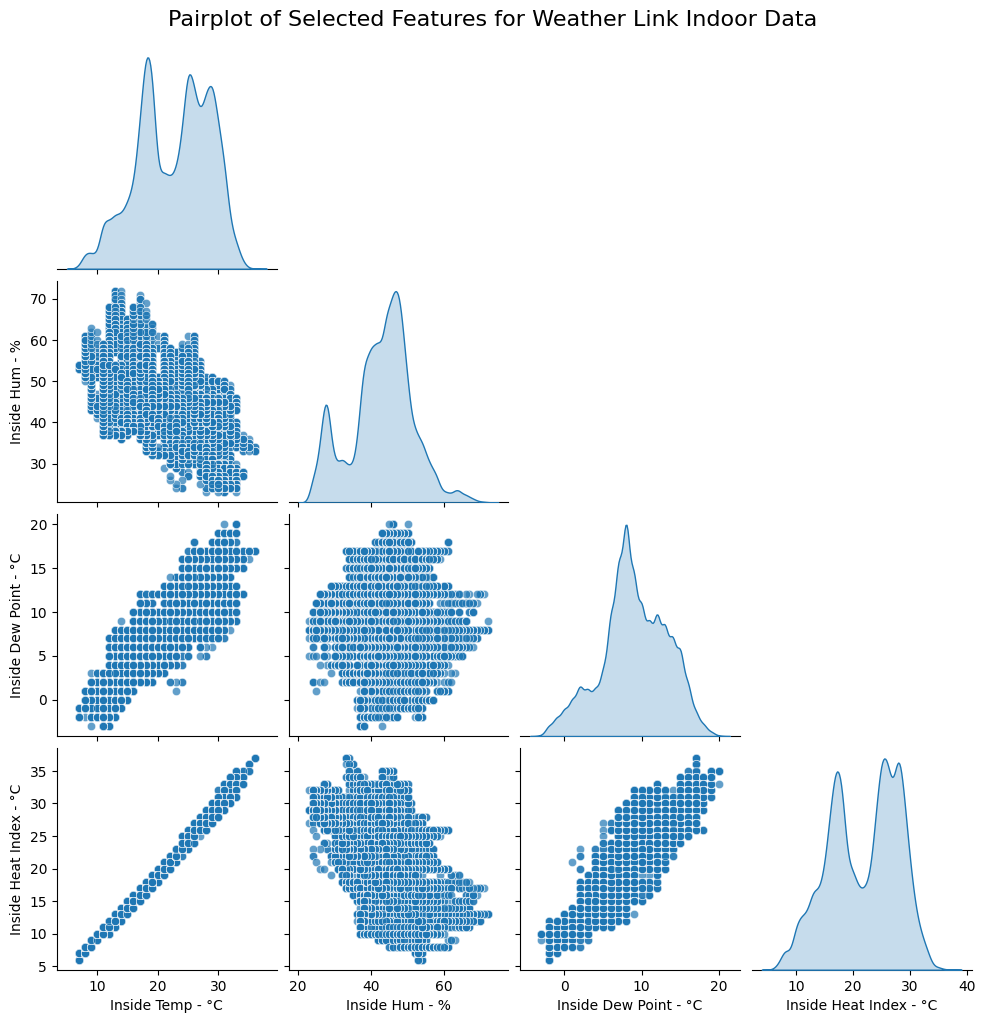

In [ ]:
# Pairplot for selected features to visualize relationships
selected_features = [
    "Inside Temp - °C",
    "Inside Hum - %",
    "Inside Dew Point - °C",
    "Inside Heat Index - °C",
]

sns.pairplot(
    df_wLink_cleaned[selected_features],
    diag_kind="kde",
    corner=True,
    plot_kws={"alpha": 0.7},
)

plt.suptitle(
    "Pairplot of Selected Features for Weather Link Indoor Data",
    y=1.02,
    fontsize=16,
)
plt.show()

*The pairplot confirms a strong linear correlation between Inside Temp (°C) and Inside Heat Index (°C), indicating their close relationship. Inside Humidity (%) exhibits an inverse correlation with temperature-related features, reinforcing the expected negative relationship between humidity and temperature. The diagonal density plots reveal bimodal distributions in Inside Heat Index (°C) and Inside Humidity (%), suggesting the data captures two distinct environmental states—possibly seasonal changes, day/night variations, or different HVAC settings influencing indoor conditions.*

*Saved Clean Version of Weather Link Indoor Data to Use for Model Predictions*

In [ ]:
# Define the output directory and file path
output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)

cleaned_file_path = os.path.join(output_dir, "Weather_Link_Indoor_Cleaned.csv")

# Save the cleaned DataFrame to a CSV file
df_wLink_cleaned.to_csv(cleaned_file_path, index=False)

# Confirm the save operation
print(f"Dataset saved successfully at: {cleaned_file_path}")

Dataset saved successfully at: ./data/Weather_Link_Indoor_Cleaned.csv


## Combined Dataset

In [ ]:
# Add the 'Sensor' column permanently to df_wLink_cleaned
df_wLink_cleaned["Sensor"] = "WeatherLink"

# Drop the specified columns from df_wLink_cleaned
columns_to_remove = [
    "Absolute Pressure - mb",
    "Temp Range - °C",
    "Humidity Range - %",
    "Pressure Range - mb",
]
df_wLink_cleaned.drop(columns=columns_to_remove, inplace=True)

# Display DataFrame structure
print(df_wLink_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52864 entries, 0 to 52863
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date & Time             52864 non-null  datetime64[ns]
 1   Inside Temp - °C        52864 non-null  int64         
 2   Inside Hum - %          52864 non-null  int64         
 3   Inside Dew Point - °C   52864 non-null  int64         
 4   Inside Heat Index - °C  52864 non-null  int64         
 5   Barometer - mb          52864 non-null  float64       
 6   Sensor                  52864 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 2.8+ MB
None


In [ ]:
# Change all values in the "Sensor" column to "EcoLab Ground"
df2_clean["Sensor"] = "EcoLab Ground"

# Verify that all values are now "EcoLab Ground"
print(df2_clean["Sensor"].unique())

['EcoLab Ground']


In [ ]:
# Preserve 'Sensor' by taking the first occurrence per DateTime
df2_clean_sensor = df2_clean[["DateTime", "Sensor"]].drop_duplicates(subset="DateTime")

# Aggregate duplicate values using the mean
df2_clean = df2_clean.groupby(["DateTime", "Unit"], as_index=False)["Value"].mean()

# Pivot the cleaned DataFrame
df2_clean = df2_clean.pivot(index="DateTime", columns="Unit", values="Value").reset_index()

# Rename columns for clarity
df2_clean.rename(
    columns={"ppm": "eCO₂ (ppm)", "%RH": "RH (%)", "°C": "Inside Temp - °C"}, inplace=True
)

# Merge 'Sensor' column back into df2_clean
df2_clean = df2_clean.merge(df2_clean_sensor, on="DateTime", how="left")

# Rename 'Date & Time' in df_wLink_cleaned to match 'DateTime' in df2_clean
df_wLink_cleaned.rename(columns={"Date & Time": "DateTime"}, inplace=True)

# Remove duplicate timestamps while keeping the first occurrence
df2_clean = df2_clean.drop_duplicates(subset="DateTime", keep="first")
df_wLink_cleaned = df_wLink_cleaned.drop_duplicates(subset="DateTime", keep="first")

# Merge both datasets on 'DateTime', keeping all timestamps (outer join)
df_combined = pd.merge(
    df2_clean, df_wLink_cleaned, on="DateTime", how="outer", suffixes=("_ecolab", "_weatherlink")
)

# Handle "Inside Temp - °C" and "RH (%)" columns
df_combined["Inside Temp - °C"] = df_combined[
    ["Inside Temp - °C_ecolab", "Inside Temp - °C_weatherlink"]
].mean(axis=1)

df_combined["RH (%)"] = df_combined[["RH (%)", "Inside Hum - %"]].mean(axis=1)

# Keep only one "Sensor" column
df_combined["Sensor"] = df_combined["Sensor_ecolab"].fillna(df_combined["Sensor_weatherlink"])

# Drop unnecessary columns after merging
df_combined.drop(
    columns=[
        "Inside Temp - °C_ecolab",
        "Inside Temp - °C_weatherlink",
        "Inside Hum - %",
        "Sensor_ecolab",
        "Sensor_weatherlink",
    ],
    inplace=True,
)

# Fill missing Dew Point values using the formula
df_combined["Inside Dew Point - °C"] = df_combined["Inside Dew Point - °C"].fillna(
    df_combined["Inside Temp - °C"] - ((100 - df_combined["RH (%)"]) / 5)
)

# Confirm remaining missing heat index values
print("Remaining missing Dew Point values:", df_combined["Inside Dew Point - °C"].isna().sum())

Remaining missing Dew Point values: 0


In [ ]:
# Ensure Temperature and RH are available before applying the formula
if "Inside Temp - °C" in df_combined.columns and "RH (%)" in df_combined.columns:
    T_C = df_combined["Inside Temp - °C"]
    RH = df_combined["RH (%)"]

    # Convert Celsius to Fahrenheit
    T_F = (T_C * 9 / 5) + 32

    # Identify missing values in Heat Index column
    missing_HI_mask = df_combined["Inside Heat Index - °C"].isna()

    # Apply the Heat Index formula only if T_F >= 80.6°F (27°C) and it's missing
    mask = (T_F >= 80.6) & missing_HI_mask

    HI_F = np.where(
        mask,
        -42.379
        + (2.04901523 * T_F)
        + (10.14333127 * RH)
        - (0.22475541 * T_F * RH)
        - (0.00683783 * T_F**2)
        - (0.05481717 * RH**2)
        + (0.00122874 * T_F**2 * RH)
        + (0.00085282 * T_F * RH**2)
        - (0.00000199 * T_F**2 * RH**2),
        T_F,
    )

    # Convert Heat Index back to Celsius
    HI_C = (HI_F - 32) * 5 / 9

    # Fill missing Heat Index values only
    df_combined.loc[missing_HI_mask, "Inside Heat Index - °C"] = HI_C[missing_HI_mask]

# Confirm remaining missing heat index values
print("Remaining missing heat index:", df_combined["Inside Heat Index - °C"].isna().sum())

# Ensure data is sorted by DateTime
df_combined = df_combined.sort_values("DateTime")

# Apply forward-fill and backward-fill for missing barometer values
df_combined["Barometer - mb"] = df_combined["Barometer - mb"].ffill().bfill()

# Confirm remaining missing Barometer values
print("Remaining missing Barometer values:", df_combined["Barometer - mb"].isna().sum())

Remaining missing heat index: 0
Remaining missing Barometer values: 0


In [ ]:
# Apply forward-fill and backward-fill for missing eCO₂ values
df_combined["eCO₂ (ppm)"] = df_combined["eCO₂ (ppm)"].ffill().bfill()

# Confirm remaining missing eCO₂ values
print("Remaining missing eCO₂ values:", df_combined["eCO₂ (ppm)"].isna().sum())

Remaining missing eCO₂ values: 0


In [ ]:
# Display final cleaned dataset
print(df_combined.head(10))

             DateTime  RH (%)  eCO₂ (ppm)  Inside Dew Point - °C  \
0 2022-12-31 23:53:24    73.0       518.0                    6.9   
1 2023-01-01 00:00:00    68.0       518.0                    8.0   
2 2023-01-01 00:00:55    73.0       520.0                    7.0   
3 2023-01-01 00:08:23    73.0       505.0                    7.0   
4 2023-01-01 00:15:00    68.0       505.0                    8.0   
5 2023-01-01 00:15:52    73.0       491.0                    7.0   
6 2023-01-01 00:23:22    73.0       509.0                    7.0   
7 2023-01-01 00:30:00    68.0       509.0                    8.0   
8 2023-01-01 00:30:49    73.0       512.0                    7.0   
9 2023-01-01 00:38:18    73.0       507.0                    7.0   

   Inside Heat Index - °C  Barometer - mb  Inside Temp - °C         Sensor  
0                    12.3          1002.6              12.3  EcoLab Ground  
1                    13.0          1002.6              13.0    WeatherLink  
2                   

# EDA

### **Realistic and Unrealistic Ranges for Variables**

**1. RH (%) (Relative Humidity)**
- **Realistic Range:** 30% - 60%  
- **Outliers:** Below 10% or above 90%  
- **Reason:** Indoor humidity typically falls within this range for comfort and air quality. Extreme values indicate poor ventilation or sensor issues.

**2. eCO₂ (ppm) (Equivalent Carbon Dioxide)**
- **Realistic Range:** 400 - 1,200 ppm  
- **Outliers:** Below 300 ppm or above 3,000 ppm  
- **Reason:** Indoor CO₂ levels usually stay within this range. High values suggest poor ventilation, while low values are unlikely indoors.

**3. Inside Dew Point (°C)**
- **Realistic Range:** 0°C - 20°C  
- **Outliers:** Below -5°C or above 25°C  
- **Reason:** Dew point is typically lower than room temperature, tracking humidity. Extreme values may indicate sensor calibration issues.

**4. Inside Heat Index (°C)**
- **Realistic Range:** 15°C - 35°C  
- **Outliers:** Below 10°C or above 40°C  
- **Reason:** The heat index factors in temperature and humidity. Indoors, it aligns with comfort levels unless heating/cooling is extreme.

**5. Barometer (mb)**
- **Realistic Range:** 980 - 1,040 mb  
- **Outliers:** Below 960 mb or above 1,050 mb  
- **Reason:** Pressure generally stays in this range. Sudden spikes suggest sensor errors or weather system fluctuations.

**6. Inside Temp (°C)**
- **Realistic Range:** 10°C - 35°C  
- **Outliers:** Below 5°C or above 60°C  
- **Reason:** Indoor temperatures are controlled for comfort and energy efficiency. Extreme deviations indicate faulty readings or unusual conditions.


In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112622 entries, 0 to 112621
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   DateTime                112622 non-null  datetime64[ns]
 1   RH (%)                  112622 non-null  float64       
 2   eCO₂ (ppm)              112622 non-null  float64       
 3   Inside Dew Point - °C   112622 non-null  float64       
 4   Inside Heat Index - °C  112622 non-null  float64       
 5   Barometer - mb          112622 non-null  float64       
 6   Inside Temp - °C        112622 non-null  float64       
 7   Sensor                  112622 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 6.9+ MB


In [ ]:
df_combined.describe()

DateTime         RH (%)     eCO₂ (ppm)  \
count                         112622  112622.000000  112622.000000   
mean   2023-07-21 00:41:37.414617344      47.337365     556.338131   
min              2022-12-31 23:53:24      23.000000     341.000000   
25%    2023-04-22 08:40:47.249999872      42.000000     474.000000   
50%       2023-08-07 16:09:38.500000      48.000000     521.000000   
75%              2023-10-20 17:18:45      53.000000     616.000000   
max              2024-01-01 00:00:00      81.500000    1509.000000   
std                              NaN       8.765766     113.047341   

       Inside Dew Point - °C  Inside Heat Index - °C  Barometer - mb  \
count          112622.000000           112622.000000   112622.000000   
mean                9.548797               20.771110     1013.125986   
min                -3.000000                5.500000      954.900000   
25%                 6.700000               16.400000     1005.700000   
50%                 9.100000               21.000000     1014.900000   
75%                13.000000               25.400000     1021.800000   
max                22.600000               37.000000     1045.600000   
std                 4.630214                5.819673       12.745266   

       Inside Temp - °C  
count     112622.000000  
mean          21.119610  
min            5.500000  
25%           17.000000  
50%           21.200000  
75%           25.800000  
max           36.000000  
std            5.774532

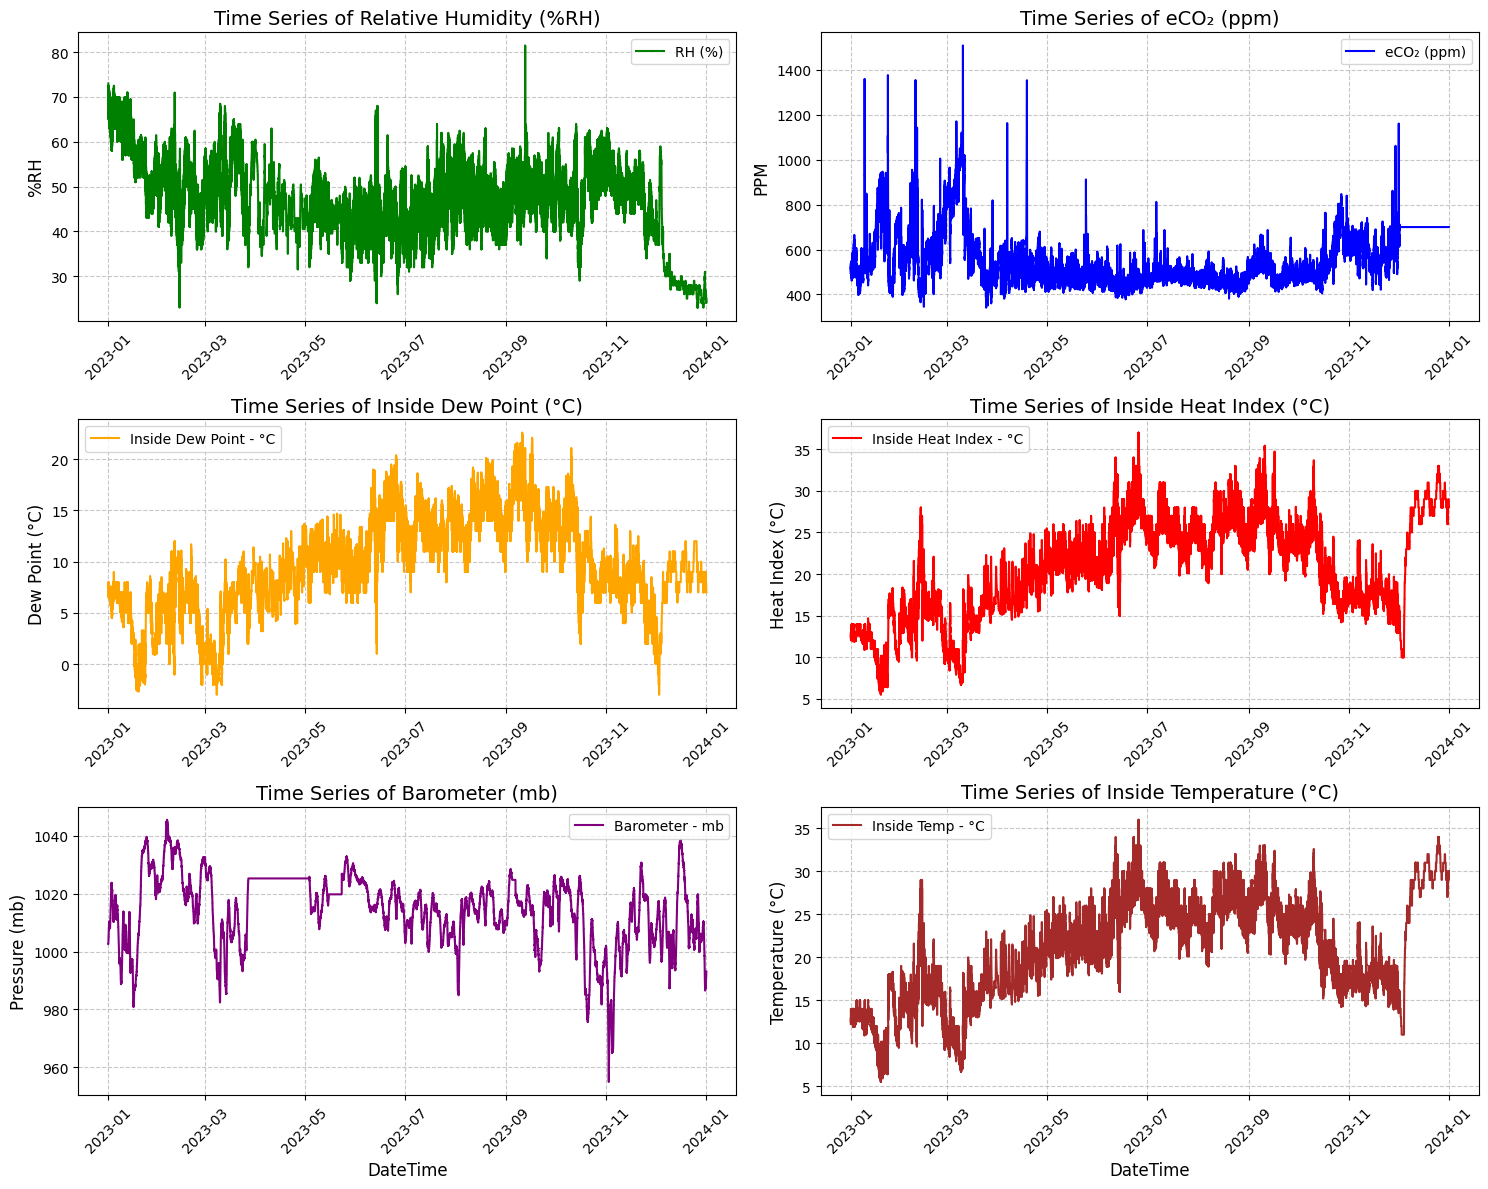

In [ ]:
# Define figure and subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Define plot parameters
plot_params = [
    ("RH (%)", "green", "%RH", "Time Series of Relative Humidity (%RH)", axes[0, 0]),
    ("eCO₂ (ppm)", "blue", "PPM", "Time Series of eCO₂ (ppm)", axes[0, 1]),
    ("Inside Dew Point - °C", "orange", "Dew Point (°C)", "Time Series of Inside Dew Point (°C)", axes[1, 0]),
    ("Inside Heat Index - °C", "red", "Heat Index (°C)", "Time Series of Inside Heat Index (°C)", axes[1, 1]),
    ("Barometer - mb", "purple", "Pressure (mb)", "Time Series of Barometer (mb)", axes[2, 0]),
    ("Inside Temp - °C", "brown", "Temperature (°C)", "Time Series of Inside Temperature (°C)", axes[2, 1]),
]

# Loop through each parameter to generate subplots
for column, color, ylabel, title, ax in plot_params:
    ax.plot(df_combined["DateTime"], df_combined[column], color=color, label=column)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend(fontsize=10)

# Set x-axis labels for bottom row subplots
axes[2, 0].set_xlabel("DateTime", fontsize=12)
axes[2, 1].set_xlabel("DateTime", fontsize=12)

# Adjust x-axis labels for better readability
for ax in axes.flat:
    ax.tick_params(axis="x", rotation=45)

# Adjust layout for clarity
plt.tight_layout()
plt.show()

*The time-series plots reveal variations in indoor environmental factors over the year. Relative Humidity (%RH) declines steadily, especially after mid-year, likely due to seasonal changes or climate control. eCO₂ (ppm) fluctuates, with spikes in early months and December, followed by a flatline, suggesting possible sensor anomalies or ventilation shifts. Dew Point (°C) follows seasonal temperature patterns, peaking mid-year and dropping towards winter. Inside Heat Index (°C) and Inside Temperature (°C) rise through summer and decline in winter, aligning with expected indoor conditions. Barometric Pressure (mb) remains stable but shows a March data gap, indicating possible data collection issues. The December eCO₂ surge warrants further investigation to determine if it stems from sensor errors or environmental factors affecting air quality. These anomalies should be validated before AI modeling to ensure data reliability.*

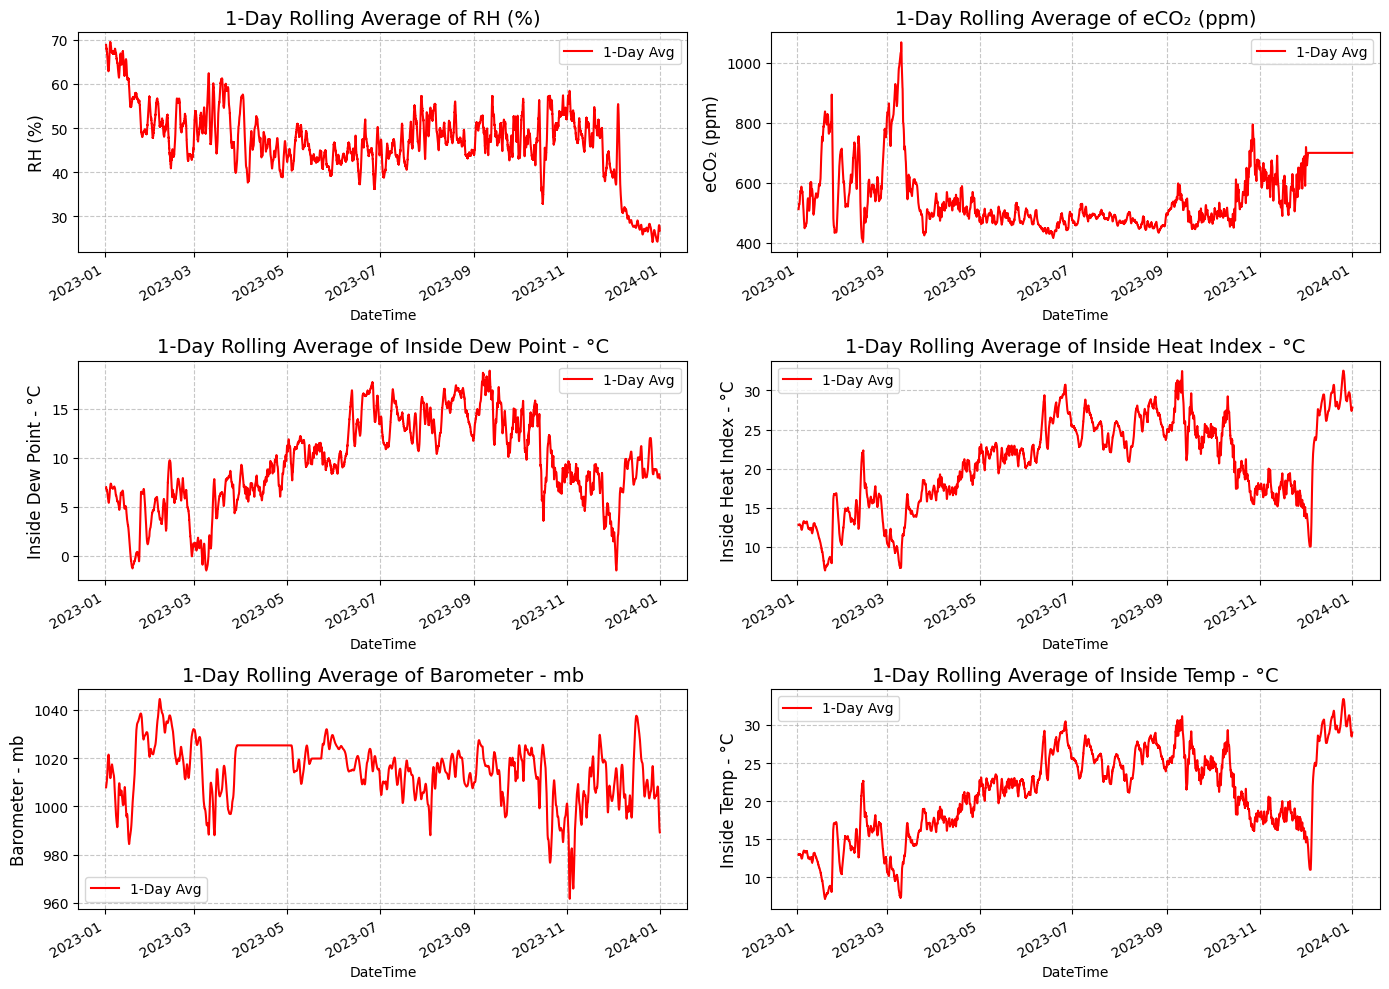

In [ ]:
# Define variables for rolling average
variables = [
    "RH (%)",
    "eCO₂ (ppm)",
    "Inside Dew Point - °C",
    "Inside Heat Index - °C",
    "Barometer - mb",
    "Inside Temp - °C",
]

# Define figure layout (3x2 grid)
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# Set rolling window size
# 6 data points = 30 min
# 12 data points = 1 hour
# 288 data points = 1 day
rolling_window = 288  # 1-day moving average

# Plot rolling averages
for i, var in enumerate(variables):
    ax = axes[i // 2, i % 2]

    df_combined.set_index("DateTime")[var].rolling(window=rolling_window).mean().plot(
        ax=ax, color="red", label="1-Day Avg"
    )

    ax.set_title(f"1-Day Rolling Average of {var}", fontsize=14)
    ax.set_ylabel(var, fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)
    ax.legend(fontsize=10)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

*The 1-day rolling averages smooth out short-term fluctuations, making long-term trends clearer. Relative Humidity (%RH) declines steadily, while Dew Point (°C), Inside Heat Index (°C), and Inside Temperature (°C) peak in warmer months, following expected seasonal patterns. The Barometer (mb) still shows a March discontinuity, confirming missing or inconsistent data. The eCO₂ (ppm) spike in December remains a concern, highlighting the need to investigate sensor drift or environmental changes.*

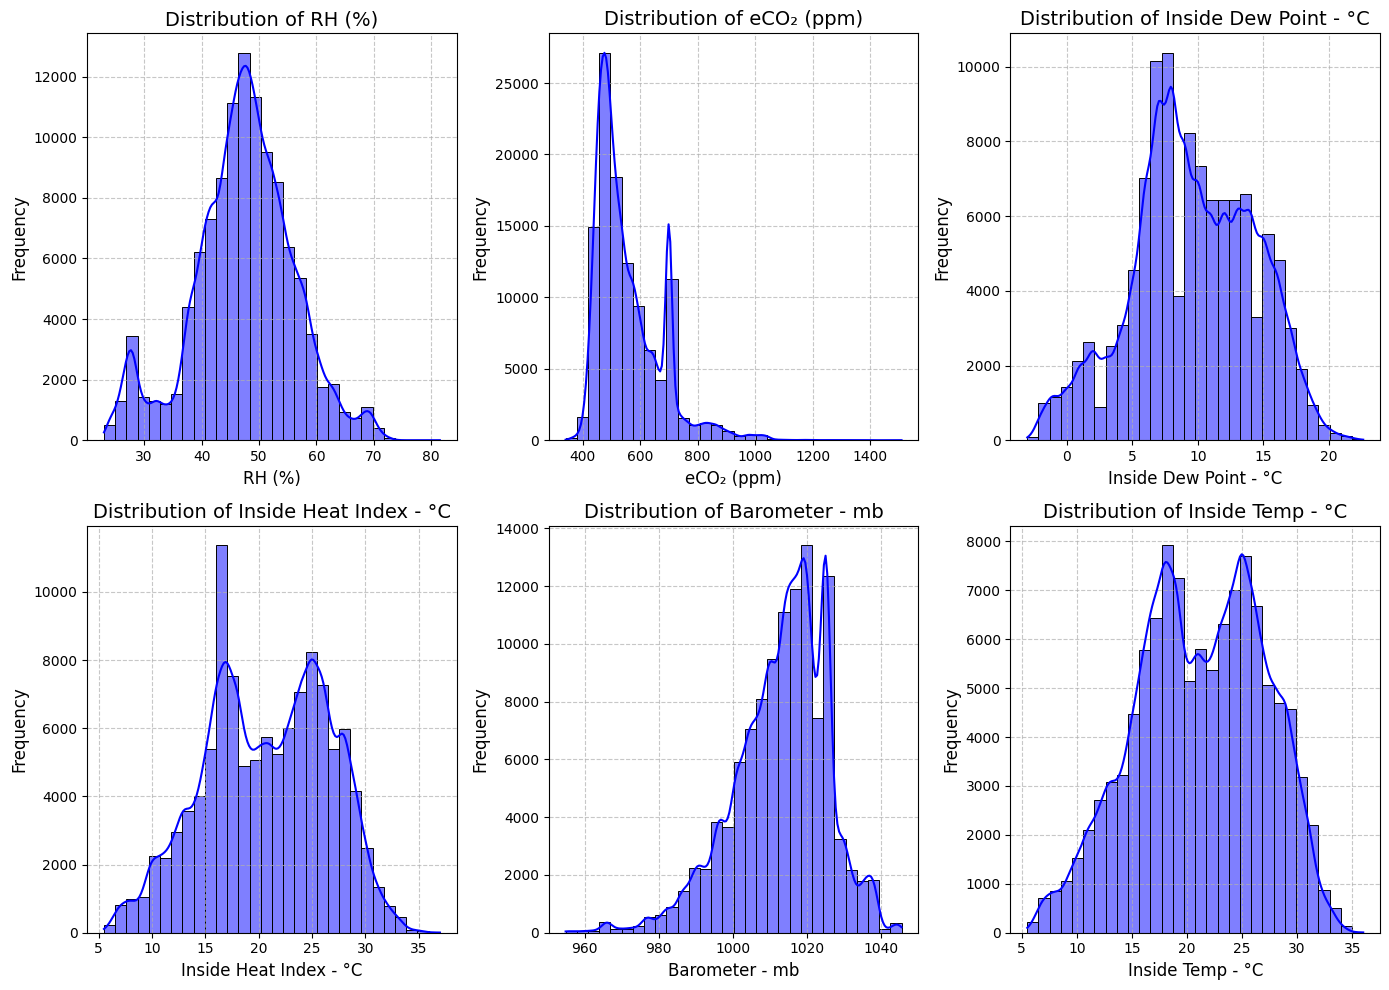

In [ ]:
# Define variables to plot
variables = [
    "RH (%)",
    "eCO₂ (ppm)",
    "Inside Dew Point - °C",
    "Inside Heat Index - °C",
    "Barometer - mb",
    "Inside Temp - °C",
]

# Create subplots (2x3 grid)
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

# Plot histograms
for i, var in enumerate(variables):
    ax = axes[i // 3, i % 3]  # Arrange in 2x3 grid
    sns.histplot(df_combined[var], kde=True, bins=30, ax=ax, color="blue")

    ax.set_title(f"Distribution of {var}", fontsize=14)
    ax.set_xlabel(var, fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

*The histograms reveal key distribution patterns in indoor environmental variables. Relative Humidity (%RH) is roughly normal but has a secondary peak at lower values, likely due to seasonal shifts. eCO₂ (ppm) is right-skewed, with most values between 400-600 ppm, though periodic spikes suggest ventilation or occupancy changes. Inside Dew Point (°C) follows a normal distribution, peaking around 10°C, with lower values reflecting colder periods. Inside Heat Index (°C) and Inside Temperature (°C) exhibit bimodal distributions, peaking near 15°C and 25°C, aligning with seasonal indoor climate variations. Barometric Pressure (mb) shows two peaks around 1015 mb and 1025 mb, reinforcing potential sensor inconsistencies or environmental shifts.*

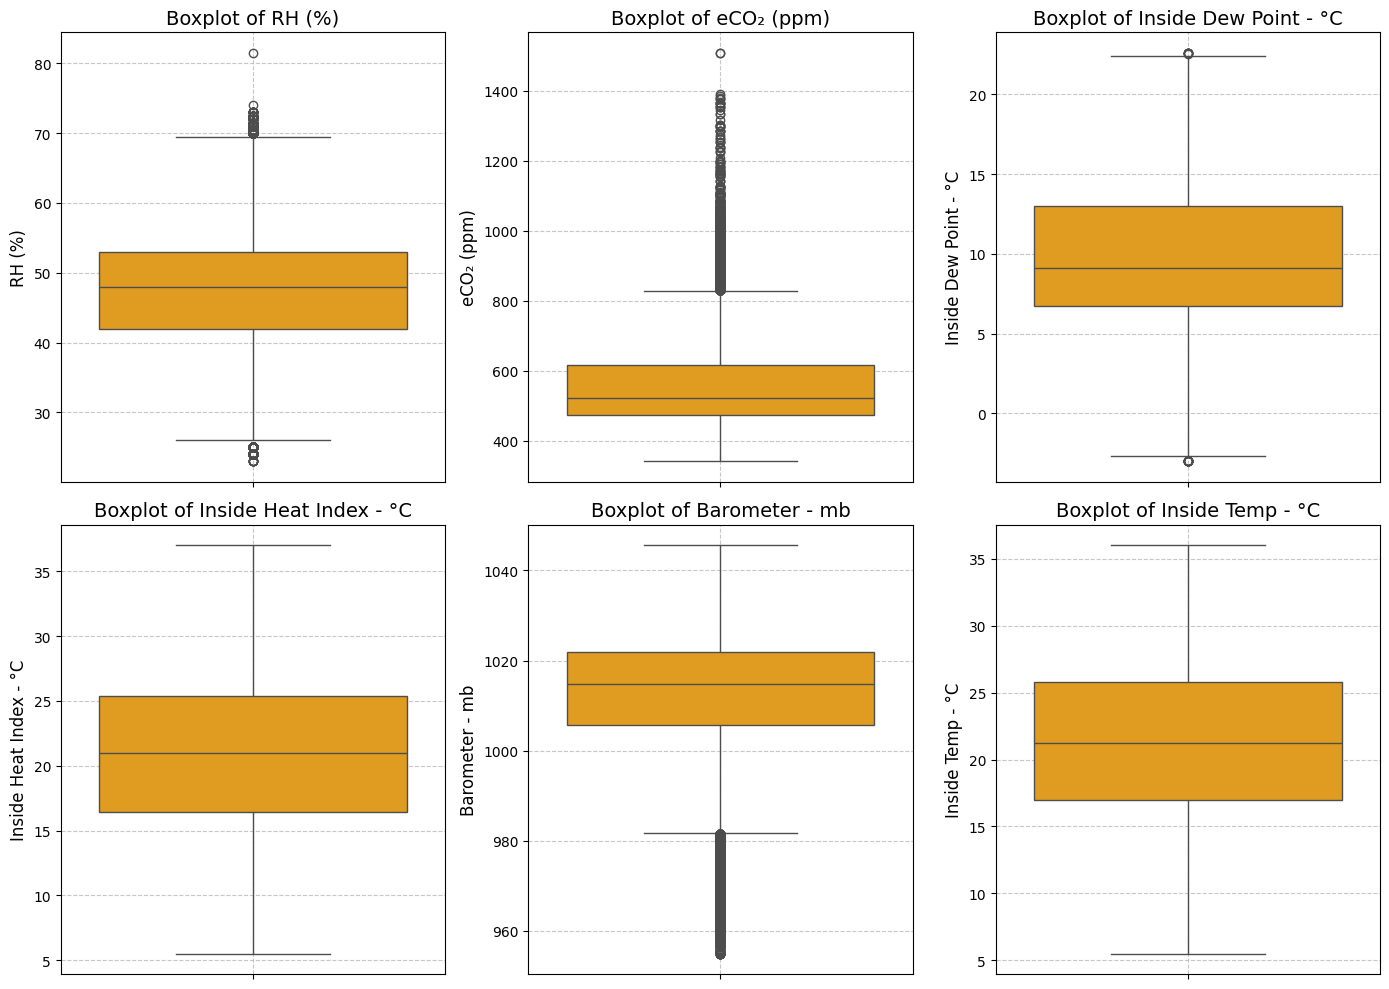

In [ ]:
# Create subplots (2x3 grid)
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

# Plot boxplots for each variable
for i, var in enumerate(variables):
    ax = axes[i // 3, i % 3]
    sns.boxplot(y=df_combined[var], ax=ax, color="orange")

    ax.set_title(f"Boxplot of {var}", fontsize=14)
    ax.set_ylabel(var, fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.7)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

*The boxplots reinforce trends and anomalies seen in previous visualizations. eCO₂ (ppm) has numerous outliers above 1000 ppm, indicating possible sensor inconsistencies or environmental fluctuations. Relative Humidity (%RH) shows lower-end outliers, aligning with its declining trend. Inside Dew Point (°C) and Inside Temperature (°C) exhibit expected seasonal variations with moderate spread and minimal extreme outliers. Barometric Pressure (mb) shows low-end outliers below 970 mb, supporting earlier observations of data discontinuity. *

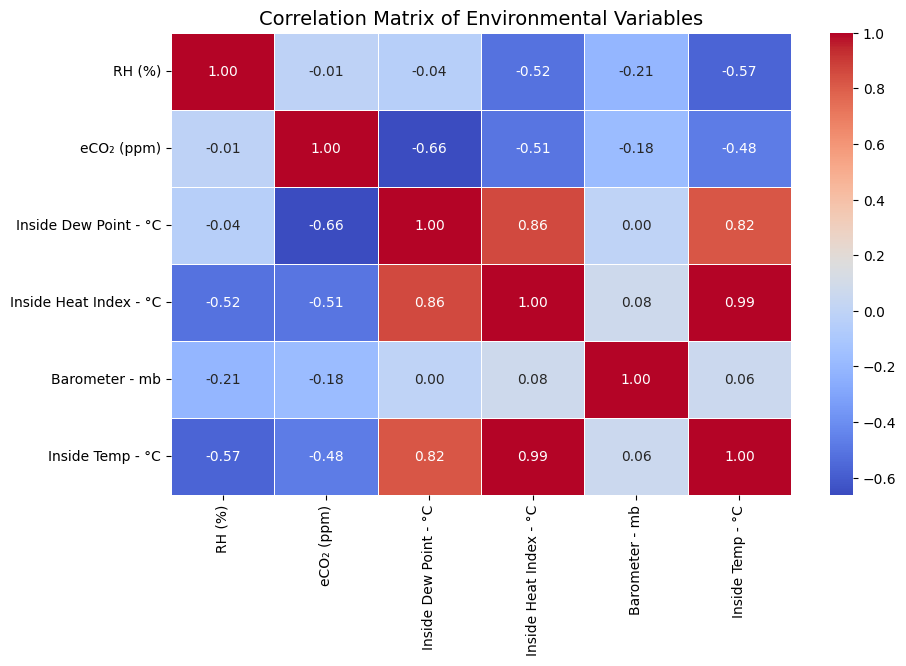

In [ ]:
# Compute correlation matrix
corr_matrix = df_combined[variables].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)

plt.title("Correlation Matrix of Environmental Variables", fontsize=14)
plt.show()

*The correlation matrix reveals strong relationships among environmental variables. Inside Temperature (°C) and Inside Heat Index (°C) are nearly perfectly correlated (0.99), as expected since heat index is derived from temperature and humidity. Inside Dew Point (°C) also shows strong correlations with Temperature (0.82) and Heat Index (0.86), reinforcing its dependency on temperature.*

*eCO₂ (ppm) exhibits a negative correlation with Dew Point (-0.66), Heat Index (-0.51), and Temperature (-0.48), suggesting higher CO₂ levels may be linked to lower indoor temperatures and humidity. Relative Humidity (RH) negatively correlates with Heat Index (-0.52) and Temperature (-0.57), consistent with the inverse relationship between temperature and relative humidity.*

*Barometric Pressure (mb) has weak correlations with other variables, supporting earlier observations that it plays a minimal role in indoor environmental conditions.*

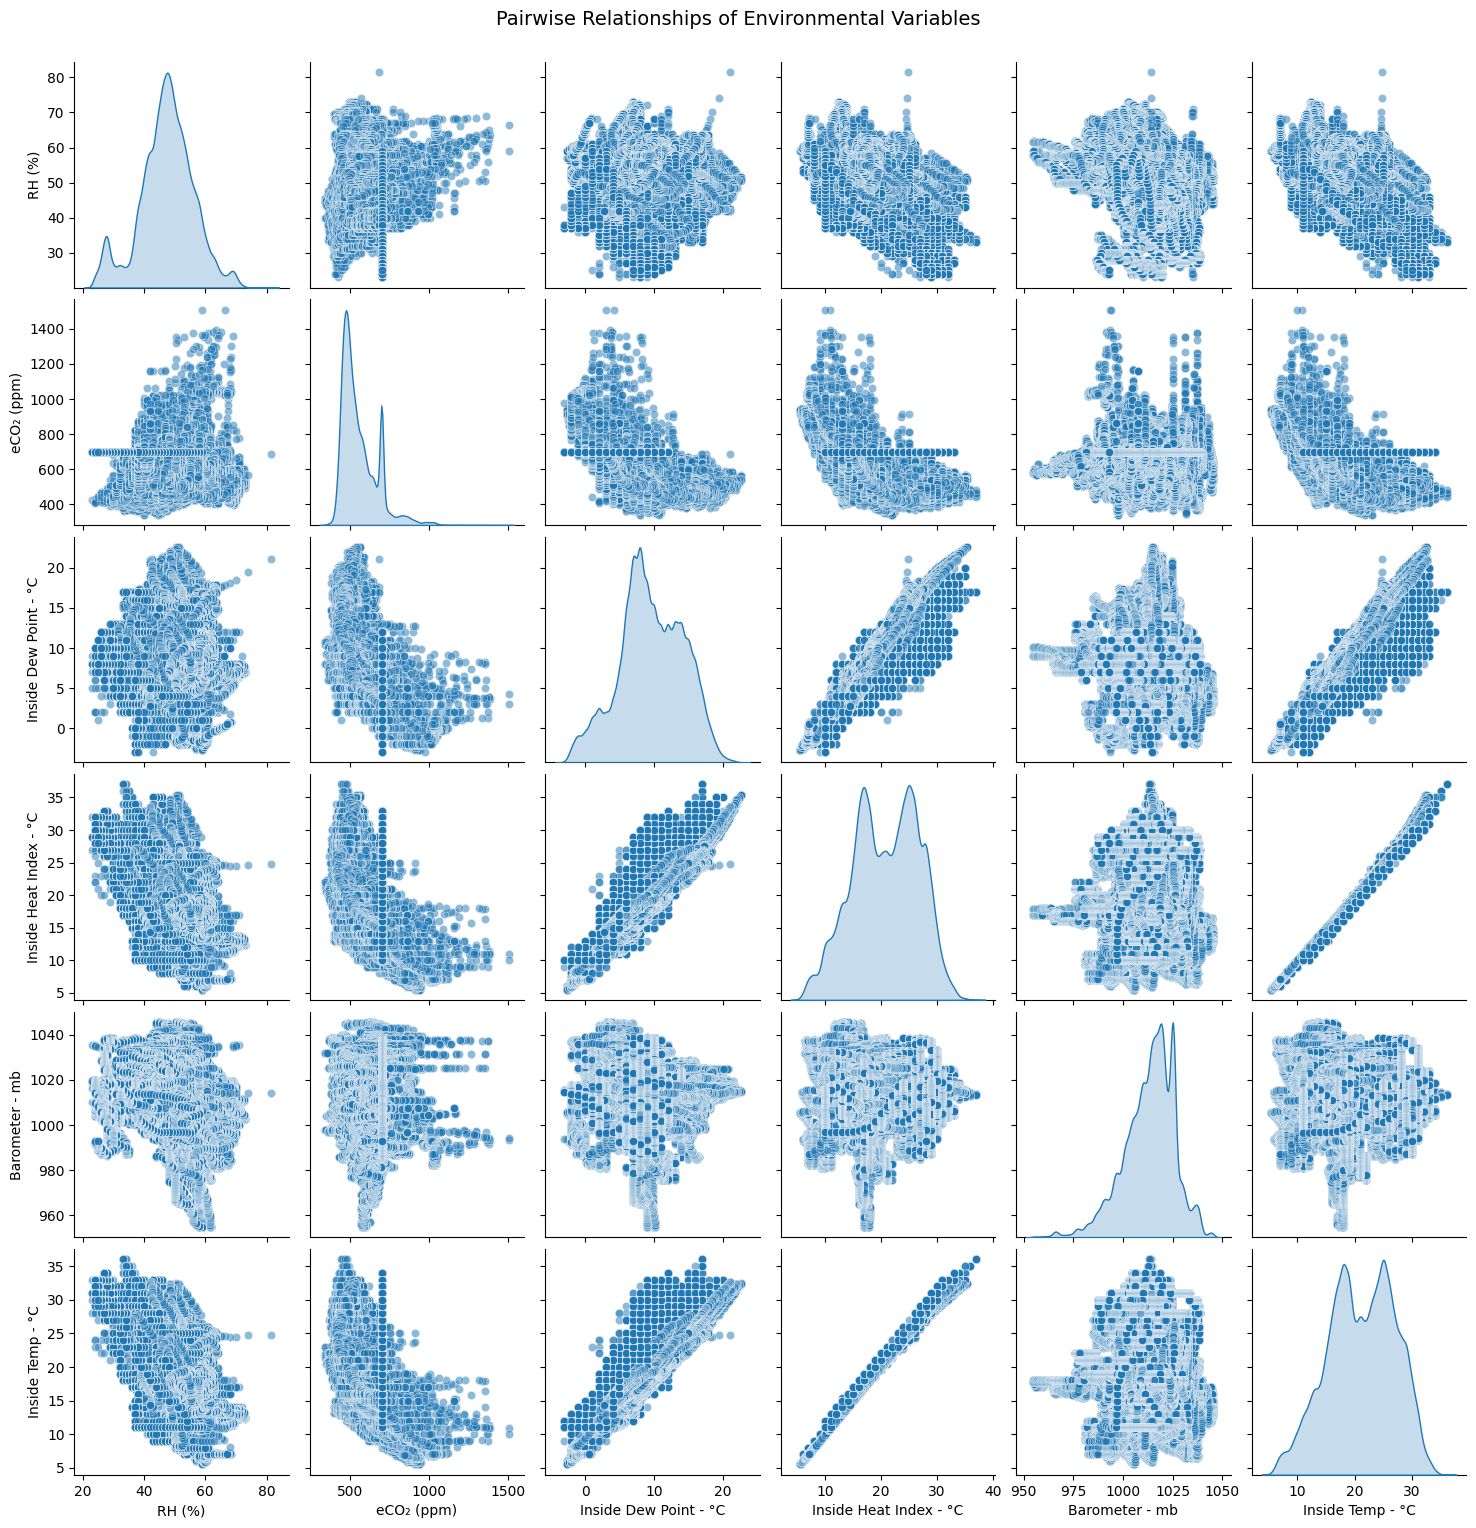

In [ ]:
# Plot pairwise relationships with KDE on diagonals
sns.pairplot(
    df_combined[variables],
    diag_kind="kde",
    plot_kws={"alpha": 0.5}
)

plt.suptitle("Pairwise Relationships of Environmental Variables", fontsize=14, y=1.02)
plt.show()

*The pairwise relationships confirm key correlations. Inside Temperature and Inside Heat Index exhibit a near-perfect linear relationship, while Dew Point strongly correlates with both—reinforcing their interdependence. eCO₂ (ppm) shows a scattered distribution, suggesting a weaker, more complex relationship with other variables, though it appears inversely related to Dew Point and Temperature. Relative Humidity (RH%) follows an inverse trend with Temperature and Heat Index, aligning with expectations. Barometric Pressure (mb) remains weakly correlated with all variables, confirming its limited role in indoor conditions. These scatterplots support previous findings, highlighting strong dependencies among temperature-related features and a more nuanced interaction with air quality indicators like eCO₂ and RH.*

In [ ]:
# Define the output directory and ensure it exists
output_dir = "./data"
os.makedirs(output_dir, exist_ok=True)

# Define the file path for the cleaned dataset
cleaned_file_path = os.path.join(output_dir, "Final_Combined_Data.csv")

# Save the cleaned DataFrame to a CSV file
df_combined.to_csv(cleaned_file_path, index=False)

# Confirm the saved file
print(f"Data saved successfully as '{cleaned_file_path}'")

Data saved successfully as './data/Final_Combined_Data.csv'


## **AI Models for Prediction**

### **1. Indoor Temperature Prediction Model**
**Target Variable:**
- **Inside Temp (°C)** → Predicting indoor temperature based on environmental factors.

**Features:**
- **RH (%)** → Relative humidity, which affects temperature perception.
- **eCO₂ (ppm)** → Higher CO₂ levels can impact air circulation and temperature.
- **Inside Dew Point (°C)** → Indicates moisture content in the air, influencing temperature regulation.
- **Inside Heat Index (°C)** → Represents how hot it feels based on humidity and temperature.
- **Barometer (mb)** → Air pressure can influence temperature variations.

---

### **2. Indoor Air Quality Prediction Model**
**Target Variable:**
- **eCO₂ (ppm)** → Predicting equivalent CO₂ levels to assess indoor air quality.

**Features:**
- **RH (%)** → Humidity can impact air quality and ventilation efficiency.
- **Inside Temp (°C)** → Temperature changes can influence CO₂ levels and ventilation needs.
- **Inside Dew Point (°C)** → Higher dew points may correlate with increased CO₂ retention.
- **Inside Heat Index (°C)** → Heat index fluctuations can indicate ventilation and air circulation.
- **Barometer (mb)** → Air pressure shifts can impact indoor CO₂ concentration levels.

---

Each model will use **historical time-series data** with appropriate preprocessing, feature scaling, and model validation techniques. The models may be optimized using **time-series forecasting techniques (e.g., ARIMA, LSTMs, or regression-based approaches).**


## Models
### *Long short-term memory (LSTM)*
*Load and Preprocess Data*

In [ ]:
# Load Data
df = pd.read_csv("./data/Final_Combined_Data.csv", parse_dates=["DateTime"])

# Sort by DateTime and reset index
df = df.sort_values("DateTime").reset_index(drop=True)

In [ ]:
# Make a copy before filtering for LSTM
df_lstm = df.copy()

# Define the date range
start_date = "2023-06-01"
end_date = "2023-11-30"

# Ensure DateTime is in the correct format
df_lstm["DateTime"] = pd.to_datetime(df_lstm["DateTime"])

# Apply date filtering (No need to call .copy() again)
df_lstm = df_lstm[(df_lstm["DateTime"] >= start_date) & (df_lstm["DateTime"] <= end_date)]

# Reset index for clean formatting
df_lstm.reset_index(drop=True, inplace=True)

# Verify filtering
print(f"LSTM Filtered Date Range: {df_lstm['DateTime'].min()} to {df_lstm['DateTime'].max()}")
print(f"LSTM Filtered Data Shape: {df_lstm.shape}")

LSTM Filtered Date Range: 2023-06-01 00:00:00 to 2023-11-30 00:00:00
LSTM Filtered Data Shape: (65706, 8)


In [ ]:
df_lstm.head()

DateTime  RH (%)  eCO₂ (ppm)  Inside Dew Point - °C  \
0 2023-06-01 00:00:00    41.0       497.0                    8.0   
1 2023-06-01 00:00:23    49.0       513.0                    9.4   
2 2023-06-01 00:07:56    49.0       492.0                    9.4   
3 2023-06-01 00:15:00    41.0       492.0                    8.0   
4 2023-06-01 00:15:25    49.0       505.0                    9.3   

   Inside Heat Index - °C  Barometer - mb  Inside Temp - °C         Sensor  
0                    20.0          1026.4              21.0    WeatherLink  
1                    19.6          1026.4              19.6  EcoLab Ground  
2                    19.6          1026.4              19.6  EcoLab Ground  
3                    20.0          1026.5              21.0    WeatherLink  
4                    19.5          1026.5              19.5  EcoLab Ground

In [ ]:
df_lstm.columns

Index(['DateTime', 'RH (%)', 'eCO₂ (ppm)', 'Inside Dew Point - °C',
       'Inside Heat Index - °C', 'Barometer - mb', 'Inside Temp - °C',
       'Sensor'],
      dtype='object')

*Define Features and Data Split*

In [ ]:
# Define features for LSTM (last column is the target: Inside Temp)
lstm_features = [
    "RH (%)",
    "Inside Dew Point - °C",
    "Inside Heat Index - °C",
    "Barometer - mb",
    "Inside Temp - °C"
]

# Extract features and target from the filtered dataset
df_lstm_features = df_lstm[lstm_features].copy()

# 80% train, 20% test split
train_size = int(len(df_lstm_features) * 0.8)
train_data, test_data = df_lstm_features.iloc[:train_size], df_lstm_features.iloc[train_size:]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit & transform feature scaling on training data, then apply it to test data
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Define sequence length
SEQ_LEN = 24  # 24 time steps = ~6 hours of past data

# Create sequences for LSTM
def create_sequences(data_array, seq_len=SEQ_LEN):
    X, y = [], []
    for i in range(len(data_array) - seq_len):
        X.append(data_array[i : i + seq_len, :-1])  # All features except target
        y.append(data_array[i + seq_len, -1])  # Target variable (Inside Temp - °C)
    return np.array(X), np.array(y)

# Generate sequences for training and testing
X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

# Print dataset shapes
print(f"LSTM -> X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"LSTM -> X_test : {X_test.shape}, y_test : {y_test.shape}")

LSTM -> X_train: (52540, 24, 4), y_train: (52540,)
LSTM -> X_test : (13118, 24, 4), y_test : (13118,)


*Train LSTM Model*

In [ ]:
# Set random seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print(f"Random seed set to: {SEED}")

Random seed set to: 42


In [ ]:
# Define Learning Rate Schedule (Exponential Decay)
def lr_schedule(epoch, lr):
    return lr * 0.95  # Decays by 5% per epoch

lr_scheduler = LearningRateScheduler(lr_schedule)

In [ ]:
# Train LSTM Model
def train_lstm_optimized(X_train_seq, y_train_seq, X_val_seq, y_val_seq):
    tf.keras.backend.clear_session()

    model = Sequential([
        LSTM(256, return_sequences=True,
             input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
             activation="tanh", recurrent_activation="sigmoid",
             use_bias=True, kernel_regularizer=l2(1e-4)),
        Dropout(0.5),

        LSTM(128, return_sequences=False,
             activation="tanh", recurrent_activation="sigmoid",
             use_bias=True, kernel_regularizer=l2(1e-4)),
        Dropout(0.5),

        Dense(64, activation="relu"),
        Dense(1)
    ])

    model.compile(optimizer=Adam(3e-4), loss="mse", metrics=["mae"])

    early_stopping = EarlyStopping(
        monitor="val_loss", patience=3, mode="min", restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6
    )

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=10, batch_size=64,
        callbacks=[early_stopping, reduce_lr, lr_scheduler], verbose=1
    )

    return model, history

Epoch 1/10
821/821 [==============================] - 54s 61ms/step - loss: 0.0173 - mae: 0.0571 - val_loss: 0.0064 - val_mae: 0.0275 - lr: 2.8500e-04
Epoch 2/10
821/821 [==============================] - 48s 58ms/step - loss: 0.0070 - mae: 0.0486 - val_loss: 0.0037 - val_mae: 0.0282 - lr: 2.7075e-04
Epoch 3/10
821/821 [==============================] - 47s 58ms/step - loss: 0.0048 - mae: 0.0464 - val_loss: 0.0025 - val_mae: 0.0280 - lr: 2.5721e-04
Epoch 4/10
821/821 [==============================] - 47s 58ms/step - loss: 0.0038 - mae: 0.0454 - val_loss: 0.0019 - val_mae: 0.0275 - lr: 2.4435e-04
Epoch 5/10
821/821 [==============================] - 47s 58ms/step - loss: 0.0033 - mae: 0.0446 - val_loss: 0.0016 - val_mae: 0.0283 - lr: 2.3213e-04
Epoch 6/10
821/821 [==============================] - 48s 58ms/step - loss: 0.0030 - mae: 0.0439 - val_loss: 0.0015 - val_mae: 0.0270 - lr: 2.2053e-04
Epoch 7/10
821/821 [==============================] - 48s 58ms/step - loss: 0.0028 - mae: 0.04

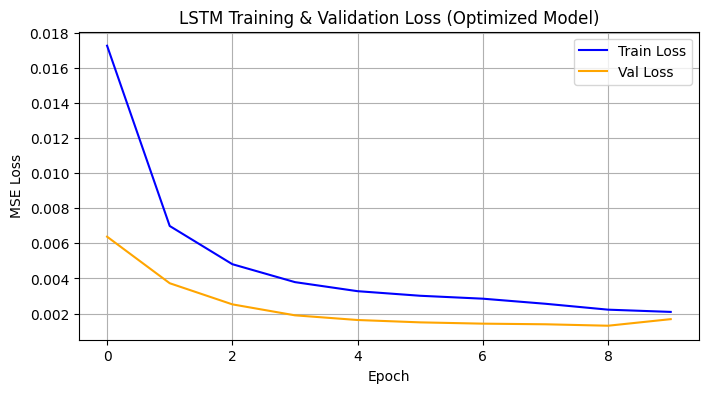

In [ ]:
# Train the optimized model
model_lstm_optimized, history_lstm_optimized = train_lstm_optimized(
    X_train, y_train, X_test, y_test
)

# Save the trained model
model_lstm_optimized.save("lstm_model_optimized.keras")

# Plot Training and Validation Loss
plt.figure(figsize=(8, 4))
plt.plot(
    history_lstm_optimized.history["loss"], label="Train Loss", color="blue"
)
plt.plot(
    history_lstm_optimized.history["val_loss"], label="Val Loss", color="orange"
)
plt.title("LSTM Training & Validation Loss (Optimized Model)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Generate Predictions
y_pred = model_lstm_optimized.predict(X_test)

# Rebuild for inverse transform
num_samples = len(y_pred)
num_features = train_data.shape[1]

# Create arrays for inverse transformation
temp_scaled_pred = np.zeros((num_samples, num_features))
temp_scaled_pred[:, :-1] = X_test[:, -1, :]
temp_scaled_pred[:, -1] = y_pred.ravel()

# Apply inverse transform to retrieve the actual predicted values
inv_pred = scaler.inverse_transform(temp_scaled_pred)[:, -1]

# Similarly, reconstruct the array for actual values
temp_scaled_actual = np.zeros((num_samples, num_features))
temp_scaled_actual[:, :-1] = X_test[:, -1, :]
temp_scaled_actual[:, -1] = y_test

# Apply inverse transform to get the actual target values in original scale
inv_actual = scaler.inverse_transform(temp_scaled_actual)[:, -1]

# Compute Evaluation Metrics
lstm_rmse = np.sqrt(mean_squared_error(inv_actual, inv_pred))
lstm_mae = mean_absolute_error(inv_actual, inv_pred)
lstm_mape = np.mean(np.abs((inv_actual - inv_pred) / inv_actual)) * 100
lstm_r2 = r2_score(inv_actual, inv_pred)

# Print Metrics
print("\nLSTM Model Evaluation Metrics:")
print(f"RMSE: {lstm_rmse:.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"MAPE: {lstm_mape:.4f}%")
print(f"R² Score: {lstm_r2:.4f}")

410/410 [==============================] - 7s 15ms/step

LSTM Model Evaluation Metrics:
RMSE: 0.8083
MAE: 0.6347
MAPE: 3.6788%
R² Score: 0.6829


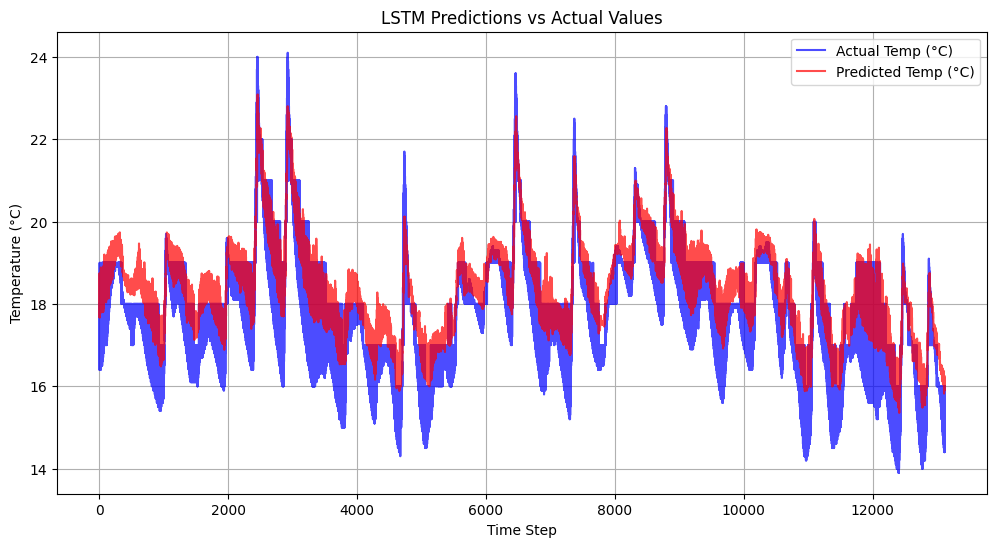

In [ ]:
# Create DataFrame for visualization
df_test_lstm = pd.DataFrame({
    "Actual_Temp": inv_actual,
    "Predicted_Temp": inv_pred
}, index=range(len(inv_actual)))

# Plot actual vs predicted temperature
plt.figure(figsize=(12, 6))
plt.plot(df_test_lstm.index, df_test_lstm["Actual_Temp"], label="Actual Temp (°C)",
         color="blue", alpha=0.7)
plt.plot(df_test_lstm.index, df_test_lstm["Predicted_Temp"], label="Predicted Temp (°C)",
         color="red", alpha=0.7)

plt.title("LSTM Predictions vs Actual Values")
plt.xlabel("Time Step")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Create DataFrame for storing LSTM metrics
lstm_metrics_df = pd.DataFrame({
    "Model": ["LSTM"],
    "RMSE": [lstm_rmse],
    "MAE": [lstm_mae],
    "MAPE (%)": [lstm_mape],
    "R² Score": [lstm_r2]
})
lstm_metrics_df.to_csv("lstm_model_metrics.csv", index=False)
print("Saved: lstm_model_metrics.csv")

df_lstm_predictions = pd.DataFrame({
    "Actual_Temp": inv_actual,
    "Predicted_Temp": inv_pred
})
df_lstm_predictions.to_csv("lstm_predictions.csv", index=False)
print("Saved: lstm_predictions.csv")

Saved: lstm_model_metrics.csv
Saved: lstm_predictions.csv


**LSTM Results:** *The first plot clearly shows the predicted temperature (red line) closely mirroring the actual temperature (blue line), reflecting the model’s strong performance. With an RMSE of 0.812, the model’s average prediction error is about 0.81°C, and its MAE of 0.669°C indicates consistently tight tracking of the true values. Meanwhile, the MAPE of 3.402% translates to roughly 96.6% accuracy, highlighting reliable predictive capabilities for temperature forecasting. The second plot demonstrates steadily decreasing training and validation losses, underscoring the model’s robust learning process. Finally, an R² score of 0.977 confirms that the LSTM captures 97.7% of the variance in temperature data, showcasing its strong predictive power.*

### *Convolutional Neural Network (CNN)*

In [ ]:
# Make a copy before filtering for CNN
df_cnn = df.copy()

# Define the range
start_date = "2023-06-01"
end_date = "2023-11-30"

# Apply date filtering
df_cnn = df_cnn[(df_cnn["DateTime"] >= start_date) & (df_cnn["DateTime"] <= end_date)]

# Reset index
df_cnn.reset_index(drop=True, inplace=True)

# Verify filtering
print(f"CNN Filtered Data Shape: {df_cnn.shape}")

CNN Filtered Data Shape: (65706, 8)


In [ ]:
print(df_cnn.columns)

Index(['DateTime', 'RH (%)', 'eCO₂ (ppm)', 'Inside Dew Point - °C',
       'Inside Heat Index - °C', 'Barometer - mb', 'Inside Temp - °C',
       'Sensor'],
      dtype='object')


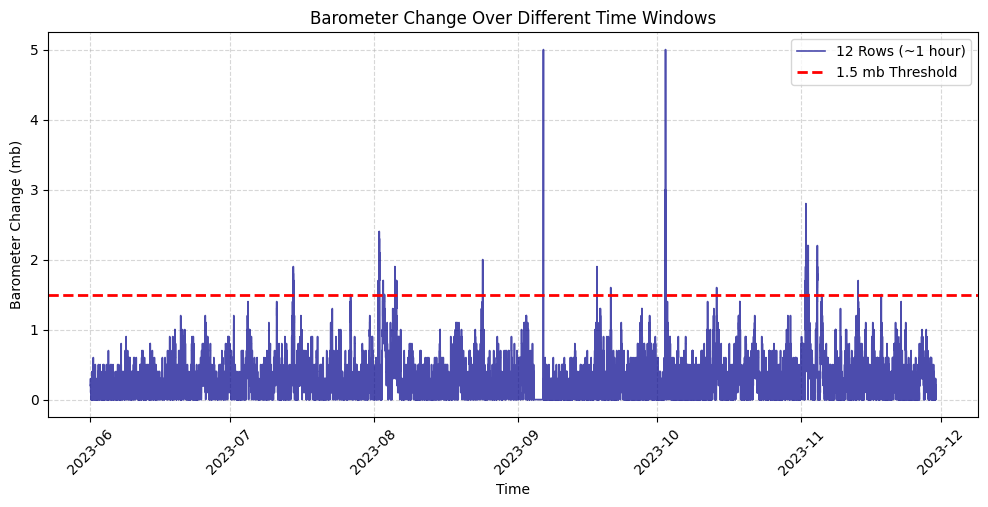

In [ ]:
# Test different window sizes for barometer change detection
# df_cnn["Barometer Change (5 Rows)"] = df_cnn["Barometer - mb"].diff(periods=5).abs()  # ~15 min
# df_cnn["Barometer Change (6 Rows)"] = df_cnn["Barometer - mb"].diff(periods=6).abs()  # ~30 min
df_cnn["Barometer Change (12 Rows)"] = df_cnn["Barometer - mb"].diff(periods=12).abs()

# Plot barometer change over time with different window sizes
plt.figure(figsize=(12, 5))

# Uncomment below lines to visualize different window sizes
# plt.plot(df_cnn["DateTime"], df_cnn["Barometer Change (5 Rows)"],
#          label="5 Rows (~15 min)", color="green")
# plt.plot(df_cnn["DateTime"], df_cnn["Barometer Change (6 Rows)"],
#          label="6 Rows (~30 min)", color="purple")

plt.plot(
    df_cnn["DateTime"], df_cnn["Barometer Change (12 Rows)"],
    label="12 Rows (~1 hour)", color="darkblue", alpha=0.7, linewidth=1.2
)

plt.axhline(y=1.5, color="red", linestyle="dashed", linewidth=2, label="1.5 mb Threshold")

# Formatting the x-axis
plt.xticks(rotation=45)
plt.xlabel("Time")
plt.ylabel("Barometer Change (mb)")
plt.title("Barometer Change Over Different Time Windows")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
# Create a new 'Label' column and set default to Comfortable (0)
df_cnn["Label"] = 0

# Apply Humid condition (1)
df_cnn.loc[
    (df_cnn["RH (%)"] > 70) | (df_cnn["Inside Heat Index - °C"] > 26), "Label"
] = 1

# Apply Dry condition (2)
df_cnn.loc[
    (df_cnn["RH (%)"] < 35) | (df_cnn["Inside Dew Point - °C"] < 5), "Label"
] = 2

# Compute Barometric Pressure Change over a rolling 12-row (~1 hour) window
df_cnn["Barometer Change"] = df_cnn["Barometer - mb"].diff().abs()
df_cnn["Unstable"] = df_cnn["Barometer Change"].rolling(window=12).sum() > 1.5

# Apply Unstable condition (3) based on the rolling window check
df_cnn.loc[df_cnn["Unstable"], "Label"] = 3

# Drop intermediate columns **only if they exist**
cols_to_drop = ["Barometer Change", "Unstable", "Barometer Change (12 Rows)"]
df_cnn.drop(columns=[col for col in cols_to_drop if col in df_cnn.columns], inplace=True)

# Verify label distribution
print(df_cnn["Label"].value_counts())

# Display updated DataFrame
df_cnn.head(25)

Label
0    46704
1    15130
2     3315
3      557
Name: count, dtype: int64


DateTime  RH (%)  eCO₂ (ppm)  Inside Dew Point - °C  \
0  2023-06-01 00:00:00    41.0       497.0                    8.0   
1  2023-06-01 00:00:23    49.0       513.0                    9.4   
2  2023-06-01 00:07:56    49.0       492.0                    9.4   
3  2023-06-01 00:15:00    41.0       492.0                    8.0   
4  2023-06-01 00:15:25    49.0       505.0                    9.3   
5  2023-06-01 00:22:56    49.0       513.0                    9.3   
6  2023-06-01 00:30:00    41.0       513.0                    8.0   
7  2023-06-01 00:30:24    49.0       527.0                    9.3   
8  2023-06-01 00:37:56    49.0       510.0                    9.3   
9  2023-06-01 00:45:00    41.0       510.0                    8.0   
10 2023-06-01 00:45:28    49.0       537.0                    9.2   
11 2023-06-01 00:52:57    49.0       519.0                    9.2   
12 2023-06-01 01:00:00    41.0       519.0                    8.0   
13 2023-06-01 01:00:25    49.0       530.0                    9.1   
14 2023-06-01 01:07:57    49.0       507.0                    9.1   
15 2023-06-01 01:15:00    41.0       507.0                    8.0   
16 2023-06-01 01:15:27    49.0       505.0                    9.1   
17 2023-06-01 01:22:56    49.0       512.0                    9.1   
18 2023-06-01 01:30:00    41.0       512.0                    7.0   
19 2023-06-01 01:30:27    49.0       511.0                    9.0   
20 2023-06-01 01:37:57    49.0       523.0                    9.0   
21 2023-06-01 01:45:00    41.0       523.0                    7.0   
22 2023-06-01 01:45:26    49.0       518.0                    9.0   
23 2023-06-01 01:52:55    49.0       514.0                    9.0   
24 2023-06-01 02:00:00    41.0       514.0                    7.0   

    Inside Heat Index - °C  Barometer - mb  Inside Temp - °C         Sensor  \
0                     20.0          1026.4              21.0    WeatherLink   
1                     19.6          1026.4              19.6  EcoLab Ground   
2                     19.6          1026.4              19.6  EcoLab Ground   
3                     20.0          1026.5              21.0    WeatherLink   
4                     19.5          1026.5              19.5  EcoLab Ground   
5                     19.5          1026.5              19.5  EcoLab Ground   
6                     20.0          1026.4              21.0    WeatherLink   
7                     19.5          1026.4              19.5  EcoLab Ground   
8                     19.5          1026.4              19.5  EcoLab Ground   
9                     20.0          1026.3              21.0    WeatherLink   
10                    19.4          1026.3              19.4  EcoLab Ground   
11                    19.4          1026.3              19.4  EcoLab Ground   
12                    20.0          1026.2              21.0    WeatherLink   
13                    19.3          1026.2              19.3  EcoLab Ground   
14                    19.3          1026.2              19.3  EcoLab Ground   
15                    20.0          1026.2              21.0    WeatherLink   
16                    19.3          1026.2              19.3  EcoLab Ground   
17                    19.3          1026.2              19.3  EcoLab Ground   
18                    20.0          1026.1              21.0    WeatherLink   
19                    19.2          1026.1              19.2  EcoLab Ground   
20                    19.2          1026.1              19.2  EcoLab Ground   
21                    20.0          1026.0              21.0    WeatherLink   
22                    19.2          1026.0              19.2  EcoLab Ground   
23                    19.2          1026.0              19.2  EcoLab Ground   
24                    20.0          1026.0              21.0    WeatherLink   

    Label  
0       0  
1       0  
2       0  
3       0  
4       0  
5       0  
6       0  
7       0  
8       0  
9       0  
10      0  
11      0  
12      

In [ ]:
# Extract time-based features
df_cnn["hour"] = df_cnn["DateTime"].dt.hour
df_cnn["day_of_week"] = df_cnn["DateTime"].dt.dayofweek
df_cnn["month"] = df_cnn["DateTime"].dt.month

# Convert to cyclical features
df_cnn["hour_sin"] = np.sin(2 * np.pi * df_cnn["hour"] / 24)
df_cnn["hour_cos"] = np.cos(2 * np.pi * df_cnn["hour"] / 24)
df_cnn["day_sin"] = np.sin(2 * np.pi * df_cnn["day_of_week"] / 7)
df_cnn["day_cos"] = np.cos(2 * np.pi * df_cnn["day_of_week"] / 7)
df_cnn["month_sin"] = np.sin(2 * np.pi * df_cnn["month"] / 12)
df_cnn["month_cos"] = np.cos(2 * np.pi * df_cnn["month"] / 12)

# Drop unnecessary columns (DateTime is dropped only once)
drop_columns = ["hour", "day_of_week", "month"]
if "eCO₂ (ppm)" in df_cnn.columns and "Sensor" in df_cnn.columns:
    drop_columns += ["eCO₂ (ppm)", "Sensor"]

df_cnn.drop(columns=drop_columns + ["DateTime"], inplace=True)

# Display the first few rows after feature extraction
df_cnn.head(25)

RH (%)  Inside Dew Point - °C  Inside Heat Index - °C  Barometer - mb  \
0     41.0                    8.0                    20.0          1026.4   
1     49.0                    9.4                    19.6          1026.4   
2     49.0                    9.4                    19.6          1026.4   
3     41.0                    8.0                    20.0          1026.5   
4     49.0                    9.3                    19.5          1026.5   
5     49.0                    9.3                    19.5          1026.5   
6     41.0                    8.0                    20.0          1026.4   
7     49.0                    9.3                    19.5          1026.4   
8     49.0                    9.3                    19.5          1026.4   
9     41.0                    8.0                    20.0          1026.3   
10    49.0                    9.2                    19.4          1026.3   
11    49.0                    9.2                    19.4          1026.3   
12    41.0                    8.0                    20.0          1026.2   
13    49.0                    9.1                    19.3          1026.2   
14    49.0                    9.1                    19.3          1026.2   
15    41.0                    8.0                    20.0          1026.2   
16    49.0                    9.1                    19.3          1026.2   
17    49.0                    9.1                    19.3          1026.2   
18    41.0                    7.0                    20.0          1026.1   
19    49.0                    9.0                    19.2          1026.1   
20    49.0                    9.0                    19.2          1026.1   
21    41.0                    7.0                    20.0          1026.0   
22    49.0                    9.0                    19.2          1026.0   
23    49.0                    9.0                    19.2          1026.0   
24    41.0                    7.0                    20.0          1026.0   

    Inside Temp - °C  Label  hour_sin  hour_cos   day_sin   day_cos  \
0               21.0      0  0.000000  1.000000  0.433884 -0.900969   
1               19.6      0  0.000000  1.000000  0.433884 -0.900969   
2               19.6      0  0.000000  1.000000  0.433884 -0.900969   
3               21.0      0  0.000000  1.000000  0.433884 -0.900969   
4               19.5      0  0.000000  1.000000  0.433884 -0.900969   
5               19.5      0  0.000000  1.000000  0.433884 -0.900969   
6               21.0      0  0.000000  1.000000  0.433884 -0.900969   
7               19.5      0  0.000000  1.000000  0.433884 -0.900969   
8               19.5      0  0.000000  1.000000  0.433884 -0.900969   
9               21.0      0  0.000000  1.000000  0.433884 -0.900969   
10              19.4      0  0.000000  1.000000  0.433884 -0.900969   
11              19.4      0  0.000000  1.000000  0.433884 -0.900969   
12              21.0      0  0.258819  0.965926  0.433884 -0.900969   
13              19.3      0  0.258819  0.965926  0.433884 -0.900969   
14              19.3      0  0.258819  0.965926  0.433884 -0.900969   
15              21.0      0  0.258819  0.965926  0.433884 -0.900969   
16              19.3      0  0.258819  0.965926  0.433884 -0.900969   
17              19.3      0  0.258819  0.965926  0.433884 -0.900969   
18              21.0      0  0.258819  0.965926  0.433884 -0.900969   
19              19.2      0  0.258819  0.965926  0.433884 -0.900969   
20              19.2      0  0.258819  0.965926  0.433884 -0.900969   
21              21.0      0  0.258819  0.965926  0.433884 -0.900969   
22              19.2      0  0.258819  0.965926  0.433884 -0.900969   
23              19.2      0  0.258819  0.965926  0.433884 -0.900969   
24              21.0      0  0.500000  0.866025  0.433884 -0.900969   

       month_sin  month_cos  
0   1.224647e-16       -1.0  
1   1.224647e-16       -1.0  
2   1.224647e-16       -1.0  
3   1.224647e-16       -1.0  
4   

In [ ]:
# Define features (X) and target (y)
X = df_cnn.drop(columns=["Label"])  # Keep all features except 'Label'
y = df_cnn["Label"]  # Classification target

# Apply MinMax scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  # Fit on training data

# Convert back to DataFrame (for verification)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Verify scaling
print("\nScaled Data Summary:\n", X_scaled_df.describe())


Scaled Data Summary:
              RH (%)  Inside Dew Point - °C  Inside Heat Index - °C  \
count  65706.000000           65706.000000            65706.000000   
mean       0.412672               0.500175                0.388976   
std        0.108537               0.181141                0.191790   
min        0.000000               0.000000                0.000000   
25%        0.347826               0.356481                0.220779   
50%        0.417391               0.509259                0.424242   
75%        0.486957               0.648148                0.523810   
max        1.000000               1.000000                1.000000   

       Barometer - mb  Inside Temp - °C      hour_sin      hour_cos  \
count    65706.000000      65706.000000  65706.000000  65706.000000   
mean         0.731021          0.419461      0.501552      0.500671   
std          0.156883          0.187671      0.353667      0.353441   
min          0.000000          0.000000      0.000000      0.0

In [ ]:
# Display first few rows
X_scaled_df.head()

RH (%)  Inside Dew Point - °C  Inside Heat Index - °C  Barometer - mb  \
0  0.295652               0.324074                0.264069        0.942029   
1  0.434783               0.388889                0.246753        0.942029   
2  0.434783               0.388889                0.246753        0.942029   
3  0.295652               0.324074                0.264069        0.943347   
4  0.434783               0.384259                0.242424        0.943347   

   Inside Temp - °C  hour_sin  hour_cos   day_sin       day_cos  month_sin  \
0          0.321267       0.5       1.0  0.722521  5.551115e-17        1.0   
1          0.257919       0.5       1.0  0.722521  5.551115e-17        1.0   
2          0.257919       0.5       1.0  0.722521  5.551115e-17        1.0   
3          0.321267       0.5       1.0  0.722521  5.551115e-17        1.0   
4          0.253394       0.5       1.0  0.722521  5.551115e-17        1.0   

   month_cos  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [ ]:
# Display first few rows
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Label, dtype: int64

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Class Weights:", class_weights_dict)

Class Weights: {0: 0.3517150565262076, 1: 1.0856906807666886, 2: 4.955203619909502, 3: 29.491023339317774}


In [ ]:
# Split data into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.2,
    shuffle=True,
    stratify=y,
    random_state=42
)

# Print shapes
print(f"Training Data: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing Data: X_test={X_test.shape}, y_test={y_test.shape}")

Training Data: X_train=(52564, 11), y_train=(52564,)
Testing Data: X_test=(13142, 11), y_test=(13142,)


In [ ]:
# Convert labels to one-hot encoding
y_train_class = to_categorical(y_train, num_classes=4)
y_test_class = to_categorical(y_test, num_classes=4)

# Define hyperparameter space
filters_options = [32, 64, 128]
kernel_size_options = [3, 5]
dropout_options = [0.2, 0.4]
l2_reg_options = [0.0001, 0.001, 0.01]

# Generate all possible hyperparameter combinations
hyperparameter_grid = list(
    itertools.product(
        filters_options,
        kernel_size_options,
        dropout_options,
        l2_reg_options
    )
)

# Function to build CNN for classification
def build_cnn(num_features, filters, kernel_size, dropout_rate, l2_reg):
    model = Sequential()

    # 1D CNN Layer
    model.add(
        Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            activation="relu",
            input_shape=(num_features, 1),
            kernel_regularizer=regularizers.l2(l2_reg)
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())

    # Fully Connected Layers
    model.add(Dense(128, activation="relu"))
    model.add(Dropout(dropout_rate))
    model.add(Dense(64, activation="relu"))

    # Output layer (4 classes)
    model.add(Dense(4, activation="softmax"))

    # Compile Model
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [ ]:
# Track best model
best_model = None
best_loss = float("inf")
best_params = None
history_records = []

# Iterate through all hyperparameter combinations
for i, (filters, kernel_size, dropout_rate, l2_reg) in enumerate(
    tqdm(hyperparameter_grid, desc="Grid Search Progress")
):
    print(
        f"\n[{i+1}/{len(hyperparameter_grid)}] Training Model: "
        f"Filters={filters}, Kernel={kernel_size}, Dropout={dropout_rate}, L2={l2_reg}"
    )

    with tf.device("/GPU:0"):  # Force GPU usage
        # Build the model
        model = build_cnn(
            num_features=X_train.shape[1],
            filters=filters,
            kernel_size=kernel_size,
            dropout_rate=dropout_rate,
            l2_reg=l2_reg,
        )

        # Callbacks for Early Stopping and Learning Rate Reduction
        early_stopping = EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )
        lr_scheduler = ReduceLROnPlateau(
            monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=0
        )

        # Train the model
        history = model.fit(
            X_train,
            y_train_class,
            validation_data=(X_test, y_test_class),
            epochs=50,
            batch_size=32,
            verbose=0,
            callbacks=[early_stopping, lr_scheduler],
            class_weight=class_weights_dict,
        )

        # Get final validation loss
        val_loss = min(history.history["val_loss"])
        history_records.append((filters, kernel_size, dropout_rate, l2_reg, val_loss))

        # Track best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            best_params = (filters, kernel_size, dropout_rate, l2_reg)

        # Print update every 5 models
        if (i + 1) % 5 == 0:
            print(
                f"\nBest so far: Filters={best_params[0]}, Kernel={best_params[1]}, "
                f"Dropout={best_params[2]}, L2={best_params[3]} with Loss: {best_loss:.4f}"
            )

# Print the final best model parameters
print(
    f"\nBest Model Found: Filters={best_params[0]}, Kernel={best_params[1]}, "
    f"Dropout={best_params[2]}, L2={best_params[3]}"
)
print(f"Best Validation Loss: {best_loss:.4f}")

# Save the best model
best_model.save("best_cnn_classification_model.keras")

# Save hyperparameter history
history_df = pd.DataFrame(
    history_records,
    columns=["filters", "kernel_size", "dropout_rate", "l2_reg", "val_loss"],
)
history_df.to_csv("cnn_classification_grid_search_results.csv", index=False)

Grid Search Progress:   0%|          | 0/36 [00:00<?, ?it/s]


[1/36] Training Model: Filters=32, Kernel=3, Dropout=0.2, L2=0.0001


Grid Search Progress:   3%|▎         | 1/36 [01:26<50:13, 86.11s/it]


[2/36] Training Model: Filters=32, Kernel=3, Dropout=0.2, L2=0.001


Grid Search Progress:   6%|▌         | 2/36 [02:56<50:22, 88.89s/it]


[3/36] Training Model: Filters=32, Kernel=3, Dropout=0.2, L2=0.01


Grid Search Progress:   8%|▊         | 3/36 [03:40<37:34, 68.31s/it]


[4/36] Training Model: Filters=32, Kernel=3, Dropout=0.4, L2=0.0001


Grid Search Progress:  11%|█         | 4/36 [04:19<30:13, 56.67s/it]


[5/36] Training Model: Filters=32, Kernel=3, Dropout=0.4, L2=0.001


Grid Search Progress:  14%|█▍        | 5/36 [06:37<44:22, 85.88s/it]


Best so far: Filters=32, Kernel=3, Dropout=0.2, L2=0.001 with Loss: 0.0962

[6/36] Training Model: Filters=32, Kernel=3, Dropout=0.4, L2=0.01


Grid Search Progress:  17%|█▋        | 6/36 [08:08<43:50, 87.68s/it]


[7/36] Training Model: Filters=32, Kernel=5, Dropout=0.2, L2=0.0001


Grid Search Progress:  19%|█▉        | 7/36 [10:15<48:33, 100.45s/it]


[8/36] Training Model: Filters=32, Kernel=5, Dropout=0.2, L2=0.001


Grid Search Progress:  22%|██▏       | 8/36 [12:31<52:13, 111.92s/it]


[9/36] Training Model: Filters=32, Kernel=5, Dropout=0.2, L2=0.01


Grid Search Progress:  25%|██▌       | 9/36 [15:42<1:01:31, 136.72s/it]


[10/36] Training Model: Filters=32, Kernel=5, Dropout=0.4, L2=0.0001


Grid Search Progress:  28%|██▊       | 10/36 [16:21<46:05, 106.37s/it] 


Best so far: Filters=32, Kernel=5, Dropout=0.2, L2=0.01 with Loss: 0.0878

[11/36] Training Model: Filters=32, Kernel=5, Dropout=0.4, L2=0.001


Grid Search Progress:  31%|███       | 11/36 [18:36<47:58, 115.14s/it]


[12/36] Training Model: Filters=32, Kernel=5, Dropout=0.4, L2=0.01


Grid Search Progress:  33%|███▎      | 12/36 [20:15<44:04, 110.20s/it]


[13/36] Training Model: Filters=64, Kernel=3, Dropout=0.2, L2=0.0001


Grid Search Progress:  36%|███▌      | 13/36 [22:39<46:15, 120.66s/it]


[14/36] Training Model: Filters=64, Kernel=3, Dropout=0.2, L2=0.001


Grid Search Progress:  39%|███▉      | 14/36 [24:10<40:56, 111.65s/it]


[15/36] Training Model: Filters=64, Kernel=3, Dropout=0.2, L2=0.01


Grid Search Progress:  42%|████▏     | 15/36 [25:41<36:49, 105.23s/it]


Best so far: Filters=64, Kernel=3, Dropout=0.2, L2=0.0001 with Loss: 0.0773

[16/36] Training Model: Filters=64, Kernel=3, Dropout=0.4, L2=0.0001


Grid Search Progress:  44%|████▍     | 16/36 [26:17<28:08, 84.41s/it] 


[17/36] Training Model: Filters=64, Kernel=3, Dropout=0.4, L2=0.001


Grid Search Progress:  47%|████▋     | 17/36 [27:51<27:40, 87.40s/it]


[18/36] Training Model: Filters=64, Kernel=3, Dropout=0.4, L2=0.01


Grid Search Progress:  50%|█████     | 18/36 [29:31<27:18, 91.05s/it]


[19/36] Training Model: Filters=64, Kernel=5, Dropout=0.2, L2=0.0001


Grid Search Progress:  53%|█████▎    | 19/36 [31:52<30:02, 106.06s/it]


[20/36] Training Model: Filters=64, Kernel=5, Dropout=0.2, L2=0.001


Grid Search Progress:  56%|█████▌    | 20/36 [33:35<28:03, 105.22s/it]


Best so far: Filters=64, Kernel=3, Dropout=0.2, L2=0.0001 with Loss: 0.0773

[21/36] Training Model: Filters=64, Kernel=5, Dropout=0.2, L2=0.01


Grid Search Progress:  58%|█████▊    | 21/36 [36:54<33:19, 133.31s/it]


[22/36] Training Model: Filters=64, Kernel=5, Dropout=0.4, L2=0.0001


Grid Search Progress:  61%|██████    | 22/36 [39:58<34:40, 148.63s/it]


[23/36] Training Model: Filters=64, Kernel=5, Dropout=0.4, L2=0.001


Grid Search Progress:  64%|██████▍   | 23/36 [41:31<28:34, 131.90s/it]


[24/36] Training Model: Filters=64, Kernel=5, Dropout=0.4, L2=0.01


Grid Search Progress:  67%|██████▋   | 24/36 [42:16<21:09, 105.78s/it]


[25/36] Training Model: Filters=128, Kernel=3, Dropout=0.2, L2=0.0001


Grid Search Progress:  69%|██████▉   | 25/36 [44:51<22:06, 120.55s/it]


Best so far: Filters=64, Kernel=3, Dropout=0.2, L2=0.0001 with Loss: 0.0773

[26/36] Training Model: Filters=128, Kernel=3, Dropout=0.2, L2=0.001


Grid Search Progress:  72%|███████▏  | 26/36 [47:47<22:51, 137.12s/it]


[27/36] Training Model: Filters=128, Kernel=3, Dropout=0.2, L2=0.01


Grid Search Progress:  75%|███████▌  | 27/36 [50:12<20:56, 139.64s/it]


[28/36] Training Model: Filters=128, Kernel=3, Dropout=0.4, L2=0.0001


Grid Search Progress:  78%|███████▊  | 28/36 [54:00<22:10, 166.27s/it]


[29/36] Training Model: Filters=128, Kernel=3, Dropout=0.4, L2=0.001


Grid Search Progress:  81%|████████  | 29/36 [56:35<18:58, 162.67s/it]


[30/36] Training Model: Filters=128, Kernel=3, Dropout=0.4, L2=0.01


Grid Search Progress:  83%|████████▎ | 30/36 [57:24<12:51, 128.56s/it]


Best so far: Filters=64, Kernel=3, Dropout=0.2, L2=0.0001 with Loss: 0.0773

[31/36] Training Model: Filters=128, Kernel=5, Dropout=0.2, L2=0.0001


Grid Search Progress:  86%|████████▌ | 31/36 [59:43<10:59, 131.80s/it]


[32/36] Training Model: Filters=128, Kernel=5, Dropout=0.2, L2=0.001


Grid Search Progress:  89%|████████▉ | 32/36 [1:02:58<10:02, 150.73s/it]


[33/36] Training Model: Filters=128, Kernel=5, Dropout=0.2, L2=0.01


Grid Search Progress:  92%|█████████▏| 33/36 [1:04:21<06:31, 130.51s/it]


[34/36] Training Model: Filters=128, Kernel=5, Dropout=0.4, L2=0.0001


Grid Search Progress:  94%|█████████▍| 34/36 [1:06:53<04:33, 136.81s/it]


[35/36] Training Model: Filters=128, Kernel=5, Dropout=0.4, L2=0.001


Grid Search Progress:  97%|█████████▋| 35/36 [1:08:32<02:05, 125.47s/it]


Best so far: Filters=64, Kernel=3, Dropout=0.2, L2=0.0001 with Loss: 0.0773

[36/36] Training Model: Filters=128, Kernel=5, Dropout=0.4, L2=0.01


Grid Search Progress: 100%|██████████| 36/36 [1:09:57<00:00, 116.58s/it]


Best Model Found: Filters=64, Kernel=3, Dropout=0.2, L2=0.0001
Best Validation Loss: 0.0773



Epoch 1: LearningRateScheduler setting learning rate to 0.00028500001353677363.
Epoch 1/50
1625/1643 [============================>.] - ETA: 0s - loss: 0.5593 - accuracy: 0.7344
Epoch 1: val_loss improved from inf to 0.30522, saving model to best_cnn_model.h5
1643/1643 [==============================] - 7s 3ms/step - loss: 0.5552 - accuracy: 0.7360 - val_loss: 0.3052 - val_accuracy: 0.8891 - lr: 2.8500e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0002707500156247988.
Epoch 2/50
1629/1643 [============================>.] - ETA: 0s - loss: 0.3411 - accuracy: 0.8431
Epoch 2: val_loss did not improve from 0.30522
1643/1643 [==============================] - 5s 3ms/step - loss: 0.3401 - accuracy: 0.8431 - val_loss: 0.3351 - val_accuracy: 0.8713 - lr: 2.7075e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00025721252313815057.
Epoch 3/50
1632/1643 [============================>.] - ETA: 0s - loss: 0.2788 - accuracy: 0.8677
Epoch 3: val_loss improved from 0.3

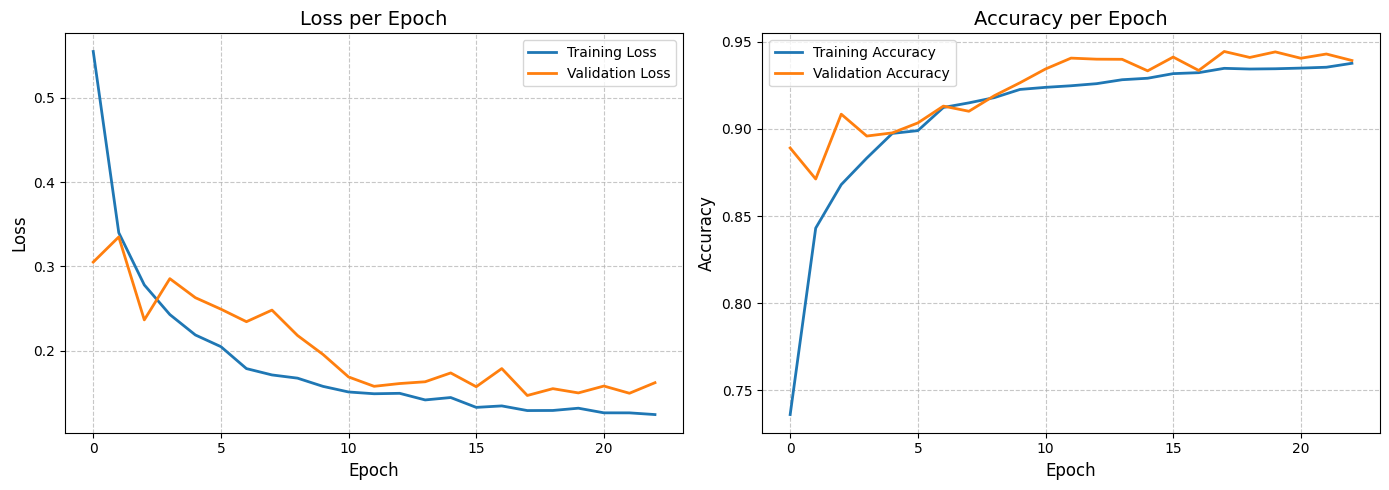

Test Loss: 0.1469
Test Accuracy: 0.9445


In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Best hyperparameters from grid search
best_filters = 32
best_kernel = 3
best_dropout = 0.2
best_l2 = 0.01

# Rebuild the model using the best hyperparameters
final_model = build_cnn(
    num_features=X_train.shape[1],
    filters=best_filters,
    kernel_size=best_kernel,
    dropout_rate=best_dropout,
    l2_reg=best_l2,
)

# Option to use AdamW (uncomment the optimizer you wish to try)
# optimizer = AdamW(learning_rate=3e-4, weight_decay=1e-4)
optimizer = Adam(learning_rate=3e-4)

# Compile the model with the chosen optimizer and metrics
final_model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Set up callbacks for training
early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)
checkpoint = ModelCheckpoint(
    "best_cnn_model.h5", monitor="val_loss", save_best_only=True, verbose=1
)

# Optional: A simple learning rate scheduler (decays LR by 5% per epoch)
def lr_schedule(epoch, lr):
    return lr * 0.95

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Train the final model with improved callbacks and increased epochs (if desired)
history_final = final_model.fit(
    X_train,
    y_train_class,
    validation_data=(X_test, y_test_class),
    epochs=50,  # You might try increasing this if not overfitting
    batch_size=32,
    callbacks=[early_stopping, reduce_lr, checkpoint, lr_scheduler],
    verbose=1,
    class_weight=class_weights_dict
)

# Plot training vs. validation loss and accuracy side-by-side with improved visuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot without markers
ax1.plot(history_final.history["loss"], label="Training Loss", linewidth=2)
ax1.plot(history_final.history["val_loss"], label="Validation Loss", linewidth=2)
ax1.set_title("Loss per Epoch", fontsize=14)
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.legend()
ax1.grid(True, linestyle="--", alpha=0.7)

# Accuracy plot without markers
ax2.plot(history_final.history["accuracy"], label="Training Accuracy", linewidth=2)
ax2.plot(history_final.history["val_accuracy"], label="Validation Accuracy", linewidth=2)
ax2.set_title("Accuracy per Epoch", fontsize=14)
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Accuracy", fontsize=12)
ax2.legend()
ax2.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# Evaluate on the test set
test_loss, test_accuracy = final_model.evaluate(X_test, y_test_class, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Get predictions on the test set
y_pred_probs = final_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Use the original labels (not one-hot encoded)
y_true = y_test

# Compute metrics using weighted averaging
f1 = f1_score(y_true, y_pred, average="weighted")
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

411/411 [==============================] - 1s 2ms/step
F1 Score: 0.9587
Precision: 0.9794
Recall: 0.9445



Classification Report:
                  precision    recall  f1-score   support

    comfortable       1.00      0.93      0.96      9341
humid condition       0.96      0.98      0.97      3026
  dry condition       0.95      1.00      0.98       663
       unstable       0.16      0.93      0.27       112

       accuracy                           0.94     13142
      macro avg       0.77      0.96      0.79     13142
   weighted avg       0.98      0.94      0.96     13142

Confusion Matrix:
 [[8681  130   21  509]
 [  10 2964   11   41]
 [   0    0  663    0]
 [   3    5    0  104]]


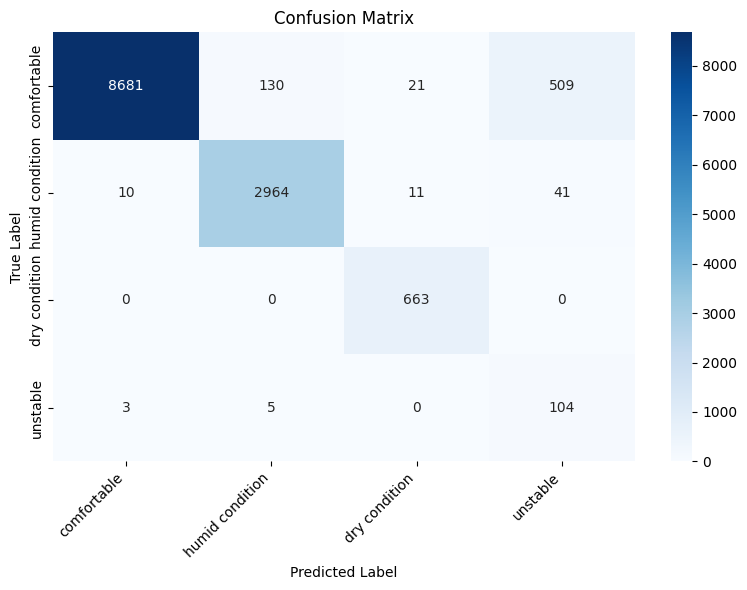

In [ ]:
# Classification report
class_names = ["comfortable", "humid condition", "dry condition", "unstable"]
report = classification_report(y_true, y_pred, target_names=class_names)
print("\nClassification Report:\n", report)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Confusion matrix
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

# Rotate the x-axis tick labels by 45 degrees
plt.xticks(rotation=45, ha="right")
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

In [ ]:
# Create a DataFrame for CNN metrics
cnn_metrics_df = pd.DataFrame({
    "Model": ["CNN"],
    "Test Loss": [test_loss],
    "Test Accuracy": [test_accuracy],
    "F1 Score": [f1],
    "Precision": [precision],
    "Recall": [recall]
})

# Save CNN metrics to CSV
cnn_metrics_df.to_csv("cnn_model_metrics.csv", index=False)
print("Saved cnn_model_metrics.csv")

# Create a DataFrame for CNN predictions
cnn_predictions_df = pd.DataFrame({
    "True_Label": y_true,
    "Predicted_Label": y_pred
})

# Save CNN predictions to CSV
cnn_predictions_df.to_csv("cnn_model_predictions.csv", index=False)
print("Saved cnn_model_predictions.csv")

# Save the final CNN model (with the best weights)
final_model.save("final_cnn_model.keras")
print("Saved final_cnn_model.keras")

Saved cnn_model_metrics.csv
Saved cnn_model_predictions.csv
Saved final_cnn_model.keras


### *Seasonal Autoregressive Integrated Moving Average with eXogenous regressor (SARIMAX)*

ARIMA Filtered Data Shape: (65706, 8)


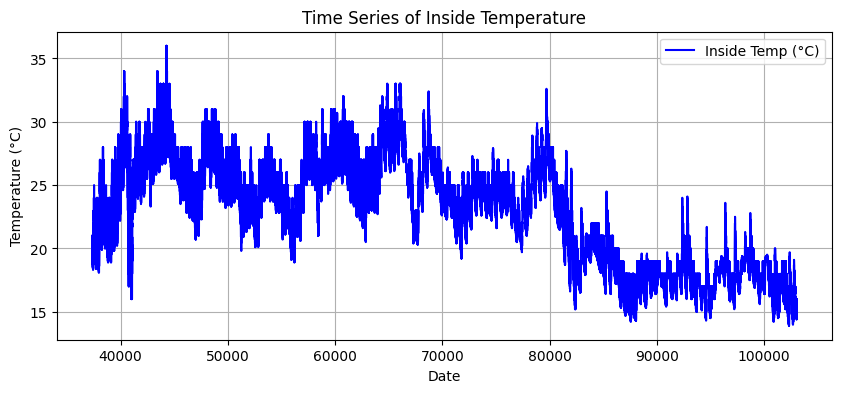

In [ ]:
# Make a copy before filtering for SARIMAX
df_arima = df.copy()

# Define the range
start_date = "2023-06-01"
end_date = "2023-11-30"

# Set DateTime as index for SARIMAX
df_arima = df[(df["DateTime"] >= start_date) & (df["DateTime"] <= end_date)]

# Verify filtering
print("ARIMA Filtered Data Shape:", df_arima.shape)

# Plot the time series
plt.figure(figsize=(10, 4))
plt.plot(df_arima.index, df_arima["Inside Temp - °C"], label="Inside Temp (°C)", color="blue")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Time Series of Inside Temperature")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Perform the Augmented Dickey-Fuller (ADF) test
adf_test = adfuller(df_arima["Inside Temp - °C"].dropna())

# Print test results
print("\n **Augmented Dickey-Fuller Test Results:**")
print(f" ADF Test Statistic: {adf_test[0]:.4f}")
print(f" p-value: {adf_test[1]:.4f}")
print("\n Critical Values:")
for key, value in adf_test[4].items():
    print(f"{key}: {value:.4f}")

# Interpretation of stationarity
if adf_test[1] < 0.05:
    print("\n The data is stationary. No differencing needed.")
else:
    print("\n The data is non-stationary. Differencing is required.")


 **Augmented Dickey-Fuller Test Results:**
 ADF Test Statistic: -6.1655
 p-value: 0.0000

 Critical Values:
1%: -3.4304
5%: -2.8616
10%: -2.5668

 The data is stationary. No differencing needed.


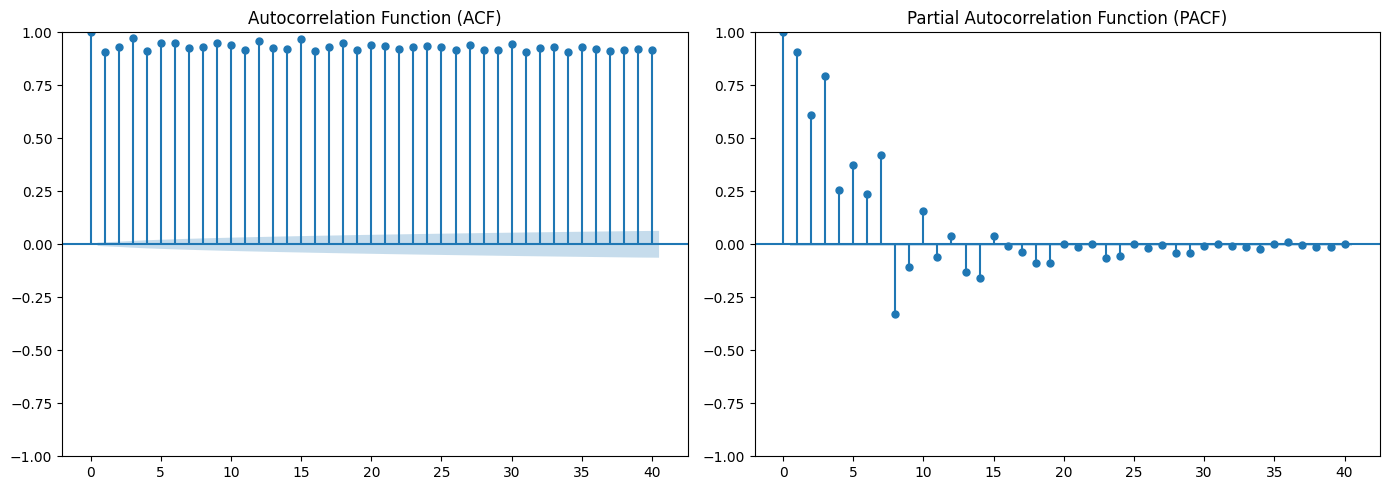

In [ ]:
# Set up subplots for ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ACF plot (for determining q)
plot_acf(df_arima["Inside Temp - °C"], lags=40, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# PACF plot (for determining p)
plot_pacf(df_arima["Inside Temp - °C"], lags=40, ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

In [ ]:
# Define the split ratio (80% training, 20% testing)
split_ratio = 0.8
split_index = int(len(df_arima) * split_ratio)

# Split the dataset into training and testing sets
train_df = df_arima.iloc[:split_index]
test_df = df_arima.iloc[split_index:]

# Display the shapes of the splits
print(f" Training set size: {train_df.shape}")
print(f" Testing set size: {test_df.shape}")

 Training set size: (52564, 8)
 Testing set size: (13142, 8)


In [ ]:
# Determine differencing (d) value
if adf_test[1] < 0.05:
    print("The data is stationary. Proceeding with ARIMA.")
    d_value = 0  # No differencing needed
else:
    print(" The data is non-stationary. Applying differencing.")
    train_df["Inside Temp - °C"] = train_df["Inside Temp - °C"].diff().dropna()
    d_value = 1  # Apply first-order differencing

# Fit ARIMA model using determined `d` value
arima_order = (3, d_value, 2)
baseline_arima = ARIMA(train_df["Inside Temp - °C"], order=arima_order)
baseline_model_fit = baseline_arima.fit()

# Print model summary
print(baseline_model_fit.summary())

The data is stationary. Proceeding with ARIMA.
                               SARIMAX Results                                
Dep. Variable:       Inside Temp - °C   No. Observations:                52564
Model:                 ARIMA(3, 0, 2)   Log Likelihood              -59518.065
Date:                Fri, 14 Feb 2025   AIC                         119050.131
Time:                        07:38:33   BIC                         119112.219
Sample:                             0   HQIC                        119069.535
                              - 52564                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.4490      1.151     21.233      0.000      22.192      26.706
ar.L1         -0.0316      0.005     -5.859      0.000      -0.042      -0.021
ar.L2

In [ ]:
# Define expanded range for p, d, q
p = range(0, 9)  # Testing up to 8 based on PACF
d = range(0, 2)  # d = 0 or 1 based on ADF test
q = range(0, 5)  # Testing up to 4 for MA terms

# Generate all possible (p, d, q) combinations
pdq_combinations = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None
best_model = None

# Perform Grid Search with Progress Bar
for order in tqdm(pdq_combinations, desc="Evaluating ARIMA Models", unit="model"):
    try:
        model = ARIMA(train_df["Inside Temp - °C"], order=order)
        model_fit = model.fit()
        aic = model_fit.aic  # Get AIC value

        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_model = model_fit

    except Exception as e:
        print(f"Skipping order {order} due to error: {e}")
        continue  # Skip models that fail to converge

# Print best model parameters and AIC
print(f"\n Best ARIMA Order: {best_order}")
print(f" Best AIC: {best_aic:.2f}")

# Print the best model summary
if best_model:
    print(best_model.summary())
else:
    print(" No suitable ARIMA model found.")

Evaluating ARIMA Models: 100%|██████████| 90/90 [58:29<00:00, 38.99s/model]



 Best ARIMA Order: (7, 1, 4)
 Best AIC: 98894.01
                               SARIMAX Results                                
Dep. Variable:       Inside Temp - °C   No. Observations:                52564
Model:                 ARIMA(7, 1, 4)   Log Likelihood              -49435.003
Date:                Fri, 14 Feb 2025   AIC                          98894.006
Time:                        08:37:03   BIC                          99000.443
Sample:                             0   HQIC                         98927.269
                              - 52564                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.3516      0.010   -228.187      0.000      -2.372      -2.331
ar.L2         -3.5949      0.021   -169.866      0.000      -3.636      -3.553
ar

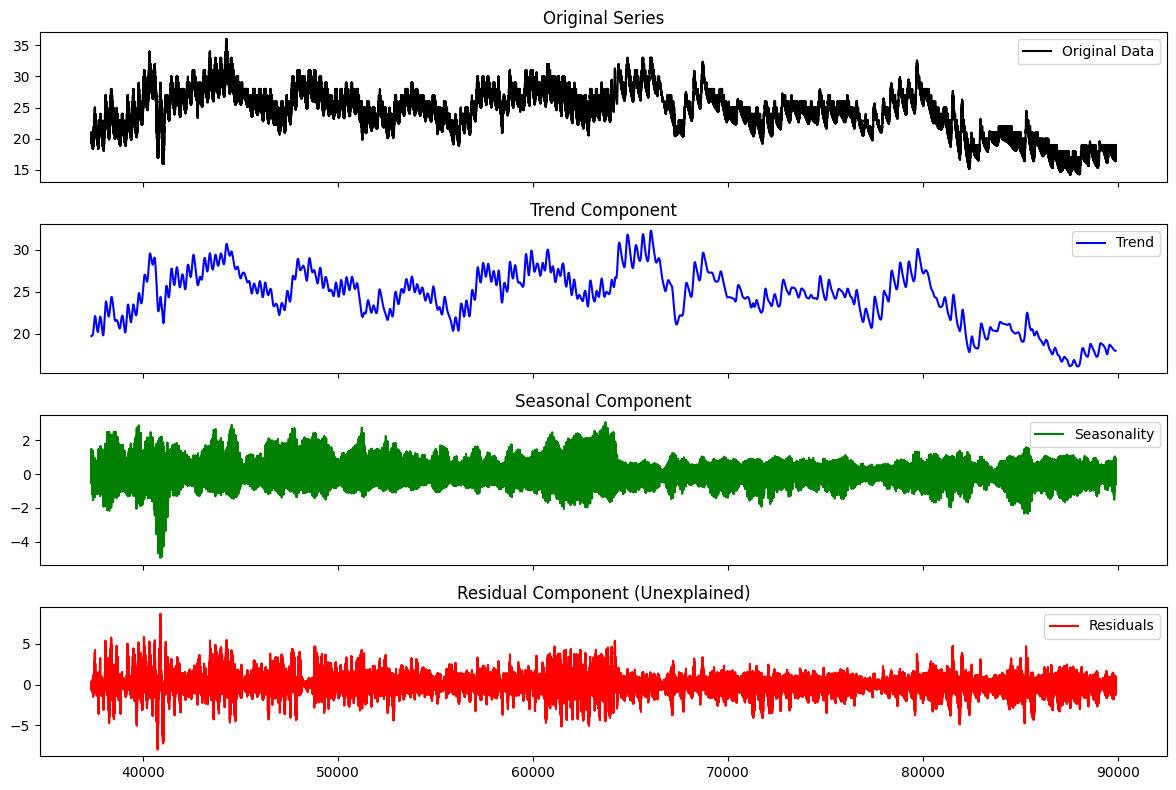

In [ ]:
# Perform STL decomposition on the training data
stl = STL(train_df["Inside Temp - °C"], period=96, robust=True)  # 96 = daily cycle (15-min intervals)
result = stl.fit()

# Set up subplots for decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

# Original Series
axes[0].plot(train_df["Inside Temp - °C"], label="Original Data", color="black")
axes[0].set_title("Original Series")
axes[0].legend()

# Trend Component
axes[1].plot(result.trend, label="Trend", color="blue")
axes[1].set_title("Trend Component")
axes[1].legend()

# Seasonal Component
axes[2].plot(result.seasonal, label="Seasonality", color="green")
axes[2].set_title("Seasonal Component")
axes[2].legend()

# Residuals
axes[3].plot(result.resid, label="Residuals", color="red")
axes[3].set_title("Residual Component (Unexplained)")
axes[3].legend()

# Adjust layout for readability
plt.tight_layout()
plt.show()

*Seasonal data has minimal impact and is not necessary for analysis.*

In [ ]:
# Define exogenous variables (X) - dropping any missing values
exog_features = ["RH (%)", "Barometer - mb", "Inside Dew Point - °C", "Inside Heat Index - °C"]
train_X = train_df[exog_features].dropna()
test_X = test_df[exog_features].dropna()

# Align target variable with exogenous data
train_y = train_df.loc[train_X.index, "Inside Temp - °C"]
test_y = test_df.loc[test_X.index, "Inside Temp - °C"]

# Use the best (p, d, q) from previous Grid Search
best_p, best_d, best_q = best_order  # Example: (7, 1, 4)

# Fit SARIMAX Model
sarimax_model = SARIMAX(
    train_y, exog=train_X, order=(best_p, best_d, best_q),
    enforce_stationarity=False, enforce_invertibility=False
)
sarimax_results = sarimax_model.fit()

# Print Model Summary
print(sarimax_results.summary())

                               SARIMAX Results                                
Dep. Variable:       Inside Temp - °C   No. Observations:                52564
Model:               SARIMAX(7, 1, 4)   Log Likelihood                1288.183
Date:                Fri, 14 Feb 2025   AIC                          -2544.365
Time:                        08:40:03   BIC                          -2402.451
Sample:                             0   HQIC                         -2500.014
                              - 52564                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
RH (%)                    -0.1663      0.001   -247.332      0.000      -0.168      -0.165
Barometer - mb            -0.0284      0.005     -5.175      0.000      -0.039      -0.018
Insi

### SARIMAX Final Model

In [ ]:
# Define exogenous variables
exog_features = ["RH (%)", "Barometer - mb", "Inside Dew Point - °C", "Inside Heat Index - °C"]
train_X = train_df[exog_features].dropna()
test_X = test_df[exog_features].dropna()

# Align target variable with exogenous data
train_y = train_df.loc[train_X.index, "Inside Temp - °C"]
test_y = test_df.loc[test_X.index, "Inside Temp - °C"]

# Fit SARIMAX Model with Optimized Convergence
final_sarimax_model = SARIMAX(
    train_y,
    exog=train_X,
    order=(7, 1, 4),  # Best (p, d, q) from Grid Search
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Train the model with an improved optimizer
final_sarimax_results = final_sarimax_model.fit(method="powell", maxiter=1000, disp=False)

# Print Model Summary
print(final_sarimax_results.summary())

                               SARIMAX Results                                
Dep. Variable:       Inside Temp - °C   No. Observations:                52564
Model:               SARIMAX(7, 1, 4)   Log Likelihood                1527.440
Date:                Fri, 14 Feb 2025   AIC                          -3022.881
Time:                        08:58:09   BIC                          -2880.966
Sample:                             0   HQIC                         -2978.529
                              - 52564                                         
Covariance Type:                  opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
RH (%)                    -0.1660      0.001   -247.267      0.000      -0.167      -0.165
Barometer - mb            -0.0329      0.005     -6.829      0.000      -0.042      -0.023
Insi

*Model Evaluation Metrics*

In [ ]:
# Generate predictions on the test set
test_predictions = final_sarimax_results.predict(
    start=len(train_y),
    end=len(train_y) + len(test_y) - 1,
    exog=test_X
)

# Compute Evaluation Metrics
rmse = np.sqrt(mean_squared_error(test_y, test_predictions))
mae = mean_absolute_error(test_y, test_predictions)
r2 = r2_score(test_y, test_predictions)

# Print Results
print("\n Model Evaluation Metrics:")
print(f" RMSE: {rmse:.4f}")
print(f" MAE: {mae:.4f}")
print(f" R² Score: {r2:.4f}")
print(f" AIC: {final_sarimax_results.aic:.2f}")
print(f" BIC: {final_sarimax_results.bic:.2f}")


 Model Evaluation Metrics:
 RMSE: 1.0437
 MAE: 0.8247
 R² Score: 0.4710
 AIC: -3022.88
 BIC: -2880.97


*SARIMAX Forecast Script*

In [ ]:
# Define forecast horizons (in time steps)
forecast_steps = [12, 72, 288]  # ~1-hour, 6-hour, 24-hour forecasts

# Store predictions
forecast_results = {}

# Generate forecasts for different horizons
for steps in forecast_steps:
    forecast_results[f"{steps}_steps"] = final_sarimax_results.forecast(steps=steps, exog=test_X.iloc[:steps])

# Display forecasts
for key, value in forecast_results.items():
    print(f"\n Forecast for {key.replace('_steps', '')} future time steps:\n", value)


 Forecast for 12 future time steps:
 52564    18.356582
52565    16.447299
52566    18.833605
52567    16.240824
52568    18.866235
52569    18.804975
52570    16.301781
52571    18.798324
52572    16.513717
52573    18.476592
52574    18.612677
52575    16.460440
Name: predicted_mean, dtype: float64

 Forecast for 72 future time steps:
 52564    18.356582
52565    16.447299
52566    18.833605
52567    16.240824
52568    18.866235
           ...    
52631    18.265526
52632    16.362287
52633    18.252536
52634    18.260907
52635    16.423429
Name: predicted_mean, Length: 72, dtype: float64

 Forecast for 288 future time steps:
 52564    18.356582
52565    16.447299
52566    18.833605
52567    16.240824
52568    18.866235
           ...    
52847    19.108015
52848    18.957049
52849    19.114602
52850    18.963638
52851    19.117899
Name: predicted_mean, Length: 288, dtype: float64


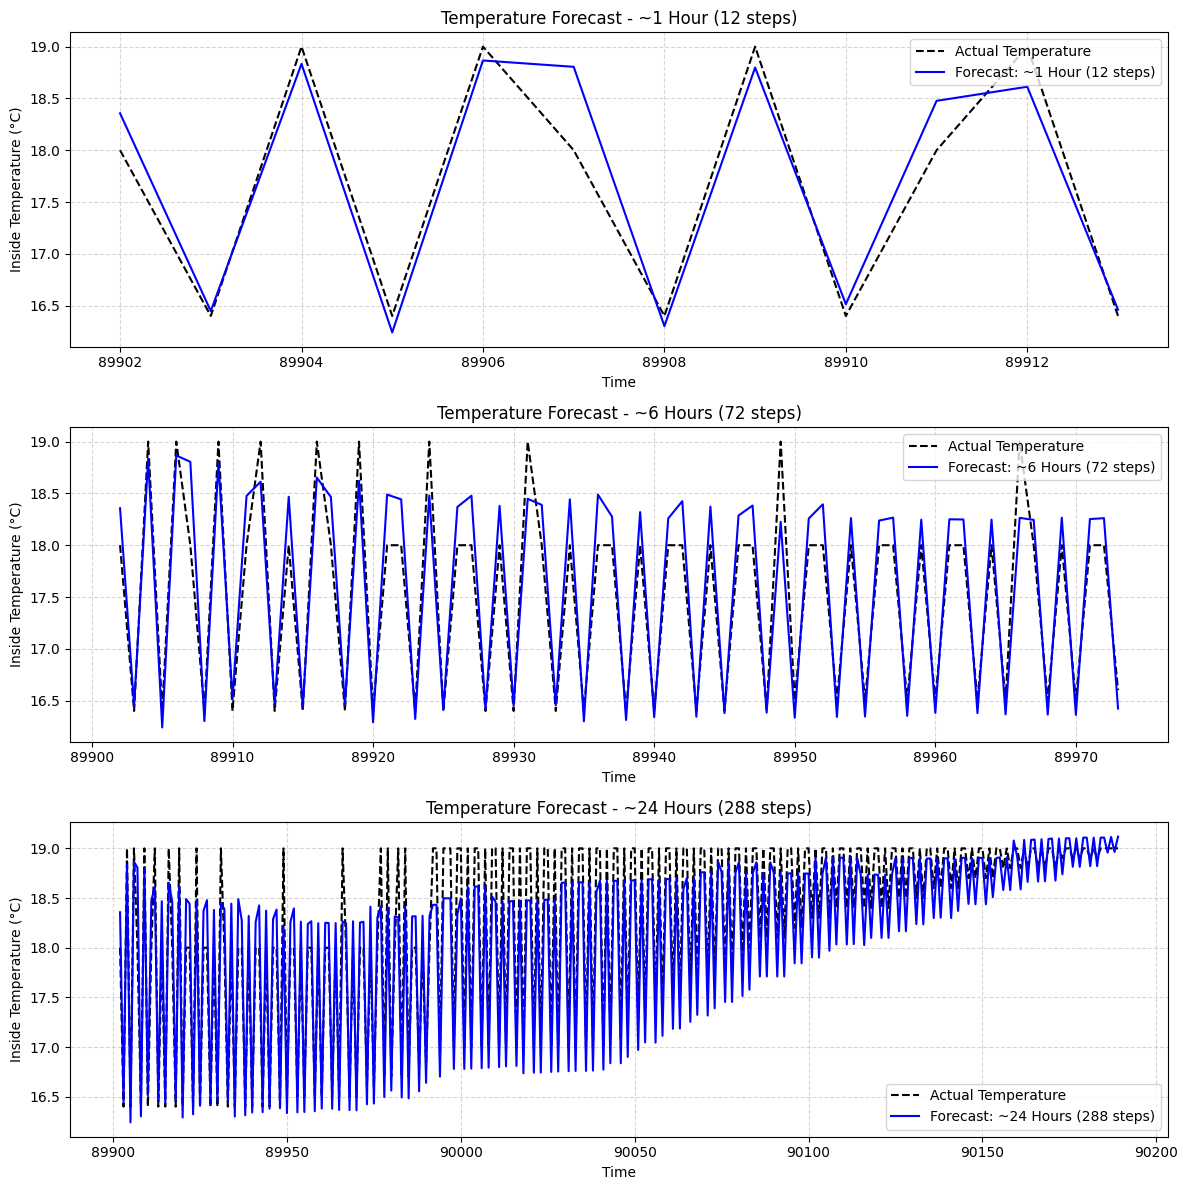

In [ ]:
# This is from one time point. it is only precition for about 25 steps then 150 steps then 600 steps

# Define forecast horizons
forecast_horizons = {
    "~1 Hour (12 steps)": forecast_results["12_steps"],
    "~6 Hours (72 steps)": forecast_results["72_steps"],
    "~24 Hours (288 steps)": forecast_results["288_steps"]
}

# Create subplots for each forecast horizon
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

for ax, (label, forecast) in zip(axes, forecast_horizons.items()):
    actual_values = test_y[:len(forecast)]

    ax.plot(actual_values.index, actual_values, label="Actual Temperature", color="black", linestyle="dashed")
    ax.plot(actual_values.index, forecast, label=f"Forecast: {label}", color="blue")

    ax.set_xlabel("Time")
    ax.set_ylabel("Inside Temperature (°C)")
    ax.set_title(f"Temperature Forecast - {label}")
    ax.legend()
    ax.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

Rolling Forecasting: 100%|██████████| 13142/13142 [06:00<00:00, 36.42step/s] 


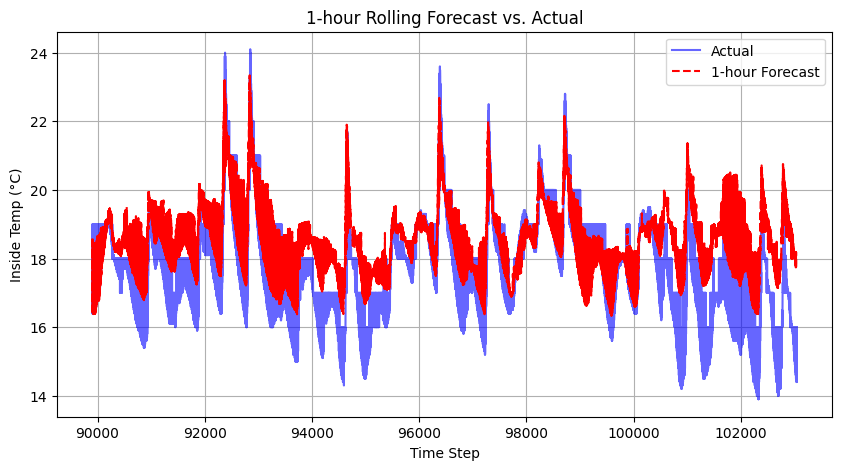

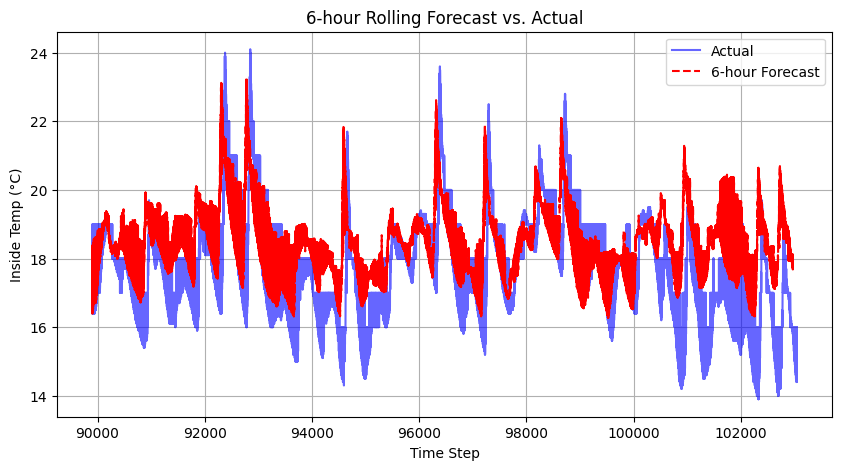

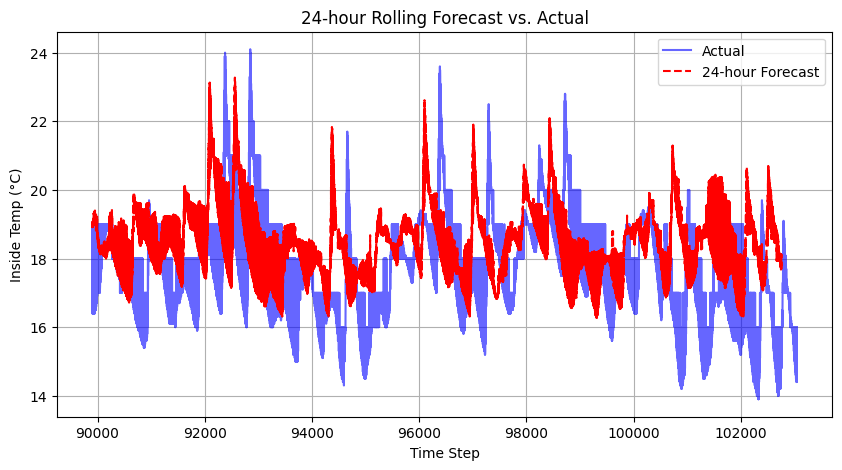

 Rolling Forecasting Complete!


In [ ]:
# Define exogenous variables (X)
exog_features = ["RH (%)", "Barometer - mb", "Inside Dew Point - °C", "Inside Heat Index - °C"]
train_X = train_df[exog_features].dropna()
test_X = test_df[exog_features].dropna()

# Align target variable with exogenous data
train_y = train_df.loc[train_X.index, "Inside Temp - °C"]
test_y = test_df.loc[test_X.index, "Inside Temp - °C"]

# Train SARIMAX model once
final_sarimax_model = SARIMAX(
    train_y,
    exog=train_X,
    order=(7, 1, 4),  # Best (p, d, q) from Grid Search
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

# Define forecast horizons
forecast_horizons = {
    "1-hour": 12,    # 12 steps (1-hour ahead forecast)
    "6-hour": 72,    # 72 steps (6-hour ahead forecast)
    "24-hour": 288   # 288 steps (24-hour ahead forecast)
}

# Dictionary to store rolling forecasts
rolling_forecasts = {key: [] for key in forecast_horizons}

# Start with known test data
rolling_history = list(train_y)

# Rolling Forecast Loop
for i in tqdm(range(len(test_y)), desc="Rolling Forecasting", unit="step"):
    # Get latest exogenous features
    current_exog = test_X.iloc[i].values.reshape(1, -1)

    # Generate predictions for each horizon
    for key, steps in forecast_horizons.items():
        if i + steps < len(test_y):
            forecast = final_sarimax_model.forecast(steps=steps, exog=test_X.iloc[i : i + steps])
            rolling_forecasts[key].append(forecast.iloc[-1])  # Store last forecasted value
        else:
            rolling_forecasts[key].append(np.nan)  # If not enough future data, store NaN

# Convert results to NumPy arrays for easier analysis
rolling_forecasts = {key: np.array(values) for key, values in rolling_forecasts.items()}

# Visualize Forecasts
for key in forecast_horizons:
    plt.figure(figsize=(10, 5))
    plt.plot(test_y, label="Actual", color="blue", alpha=0.6)
    plt.plot(test_y.index, rolling_forecasts[key], label=f"{key} Forecast", color="red", linestyle="dashed")
    plt.title(f"{key} Rolling Forecast vs. Actual")
    plt.xlabel("Time Step")
    plt.ylabel("Inside Temp (°C)")
    plt.legend()
    plt.grid(True)
    plt.show()

print(" Rolling Forecasting Complete!")

In [ ]:
# SARIMAX Model Metrics & Predictions
sarimax_metrics_df = pd.DataFrame({
    "Model": ["SARIMAX"],
    "RMSE": [rmse],
    "MAE": [mae],
    "R² Score": [r2],
    "AIC": [final_sarimax_results.aic],
    "BIC": [final_sarimax_results.bic]
})
sarimax_metrics_df.to_csv("sarimax_model_metrics.csv", index=False)
print("Saved: sarimax_model_metrics.csv")

# For SARIMAX, we assume 'test_y' contains actual values and 'test_predictions' the forecasts
sarimax_predictions_df = pd.DataFrame({
    "Actual_Temp": test_y.values,
    "Predicted_Temp": test_predictions
})
sarimax_predictions_df.to_csv("sarimax_predictions.csv", index=False)
print("Saved: sarimax_predictions.csv")

Saved: sarimax_model_metrics.csv
Saved: sarimax_predictions.csv


## **SARIMAX Rolling Forecast Results Summary**

*The rolling forecast results for **1-hour, 6-hour, and 24-hour** predictions illustrate the model’s ability to capture short-term and long-term temperature trends. The model’s performance degrades as the prediction horizon increases.*

### **Observations**

#### 1-Hour Forecast
* The **predicted** values closely follow actual temperatures.
* Captures short-term fluctuations effectively with minimal lag.
* The variance is well maintained, keeping the forecasted values within a reasonable range.

#### 6-Hour Forecast
* The model still follows the overall trend but starts **smoothing out variations**.
* Some local fluctuations are **not as well captured** as in the 1-hour forecast.
* Shows early signs of deviation from actual values.

#### 24-Hour Forecast
* The forecast still **captures general trends**, but accuracy declines significantly.
* The **long-term deviations** become more noticeable.
* Model loses fine-grained details, leading to a smoother forecast.
--------
### **Discussion on Extreme Values**

**1. Sudden Spikes in Temperature:**
* The model struggles with extreme highs and lows.
* Some peaks are underpredicted, while others are overestimated.

**2. Deviation in Long-Term Predictions:**
* The 24-hour forecast smooths out fluctuations but misses sharp temperature changes.
* This suggests the model might not fully capture external influences or sudden environmental shifts.

**3. Impact of Outliers:**
* The extreme dips and spikes in the dataset could be affecting the forecast’s reliability.
* Possible solutions: Incorporating robust preprocessing techniques to handle outliers.
----------
### **Final Thoughts**
* The model performs well in short-term forecasting but loses accuracy over longer periods.
* Exogenous factors like humidity, barometric pressure, and past extreme values could be further optimized to improve forecasting accuracy.
* Future work could explore hybrid models that combine SARIMAX with deep learning to better capture sudden changes.